# Employee Attrition prediction models 

In [0]:
# Install packages
!pip install imbalanced-learn
!pip install --upgrade numpy scipy threadpoolctl  
!pip install xgboost 
!pip install catboost   
!pip install lightgbm
!pip install shap

In [0]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, f1_score, cohen_kappa_score
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier  
from catboost import CatBoostClassifier
import numpy as np
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lightgbm
from lightgbm import LGBMClassifier


In [0]:
# Load cleaned data extended model
df_employees_cleaned = pd.read_csv("Employee_attrition_cleaned2.csv")

In [0]:
# Drop features that are disregarded in model 
df_employees_cleaned = df_employees_cleaned.drop(columns=["AnonymizedEmployeeCode", "CompanyID", "City", "YearsInServiceGroupNew"])


In [0]:
# Exclude novel features for dataframe baseline model
columns_to_exclude = [
    "ManualLabor_Yes",
    "NumContractTypeChanges",
    "NumFunctionChanges",
    "NumLocationChanges",
    "NumOrganisationPartChanges",
    "SalaryIncreasesCount",
    "YearsCurrentContractType",
    "YearsCurrentDepartment",
    "YearsCurrentFunction",
    "YearsCurrentLocation",
    "YearsCurrentOrganisationPart"
]

# Create df_employees_baseline_features by excluding specified columns
df_employees_baseline_features = df_employees_cleaned.drop(columns=columns_to_exclude)

# Feature Encoding 

## Ordinal encoding AgeGroup

In [0]:
# Define the order of the AgeGroup
age_order = [
    'under 20',   # 0
    '20-24',      # 1
    '25-29',      # 2
    '30-34',      # 3
    '35-39',      # 4
    '40-44',      # 5
    '45-49',      # 6
    '50-54',      # 7
    '55-59',      # 8
    '60-64',      # 9
    '65+'         # 10
]

# Create a mapping from AgeGroup to ordinal values
age_mapping = {age: idx for idx, age in enumerate(age_order)}

# Overwrite the AgeGroup column with the encoded values
df_employees_cleaned['AgeGroup'] = df_employees_cleaned['AgeGroup'].map(age_mapping)
df_employees_baseline_features['AgeGroup'] = df_employees_baseline_features['AgeGroup'].map(age_mapping)

## Ordinal encoding Generation 

In [0]:
# Define the order of generations
generation_order = [
    'Silent Generation (1926-1940)',
    'Protest Generation (1941-1955)',
    'Generation X (1956-1970)',
    'Pragmatic Generation (1971-1985)',
    'Generation Y (1986-2000)',
    'Generation Z (2001-2015)',
    'Generation Alpha (2016-2030)'
]

# Create a mapping from generation to ordinal number
generation_mapping = {generation: index for index, generation in enumerate(generation_order)}

# Perform ordinal encoding
df_employees_cleaned['Generation'] = df_employees_cleaned['Generation'].replace(generation_mapping)
df_employees_baseline_features['Generation'] = df_employees_baseline_features['Generation'].replace(generation_mapping)

## Ordinal encoding YearDateService

In [0]:
# Define the year range
min_year = 1977
max_year = 2024

# Create a mapping from year to ordinal value
year_mapping = {year: year - min_year for year in range(min_year, max_year + 1)}

# Overwrite the YearDateService column with its ordinal encoding
df_employees_cleaned['YearDateService'] = df_employees_cleaned['YearDateService'].map(year_mapping)
df_employees_baseline_features['YearDateService'] = df_employees_baseline_features['YearDateService'].map(year_mapping)

## Ordinal encoding FunctionCategory

In [0]:
# Define the order of categories
category_order = [
    'Intern', 
    'Flex worker', 
    'Junior', 
    'General Level', 
    'Medior', 
    'Lead or Supervisor', 
    'Manager', 
    'Senior', 
    'Partner and C-level'
]

# Create a mapping from category to ordinal number
category_mapping = {category: index for index, category in enumerate(category_order)}

# Perform ordinal encoding
df_employees_cleaned['FunctionCategory'] = df_employees_cleaned['FunctionCategory'].replace(category_mapping)
df_employees_baseline_features['FunctionCategory'] = df_employees_baseline_features['FunctionCategory'].replace(category_mapping)

## One-hot encoding

In [0]:
# Specify the features to be one-hot encoded
features_to_encode_complete_model = ["Gender", "Country", "EmployeeType", "MaritalStatus", "DepartmentCategory", "ManualLabor", "ContractType", "CompanySize", "Industry"] 

features_to_encode_baseline_model = ["DepartmentCategory", "CompanySize", "Gender", "MaritalStatus"]

# Apply one-hot encoding and overwrite the original DataFrame
df_employees_cleaned = pd.get_dummies(df_employees_cleaned, columns=features_to_encode_complete_model, drop_first=True)
df_employees_baseline_features = pd.get_dummies(df_employees_baseline_features, columns=features_to_encode_baseline_model, drop_first=True)

## Feature Selection

In [0]:
df_employees_cleaned = df_employees_cleaned.drop(["YearsInService", "Generation"], axis=1)

# Extended Models

## Decision Tree

### Hyperparameter tuning

In [0]:
# Prepare the feature variables (X) and target variable (y)
X = df_employees_cleaned.drop(columns=["Attrition"])  # Features
y = df_employees_cleaned["Attrition"]  # Target variable

# Convert the target variable to numeric (0 = 'No', 1 = 'Yes')
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the dataset into training and a completely separate test set (20% test size)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Initialize StratifiedKFold for cross-validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter grid for Decision Tree
param_grid = {
    'criterion': ['gini', 'entropy'],  # Split criterion
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],    # Minimum number of samples at a leaf node
    'max_features': [None, 'sqrt', 'log2'],  # Number of features to consider at each split
    'splitter': ['best', 'random']  # Strategy used to split at each node
}

# Initialize Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=dt_classifier,
    param_grid=param_grid,
    scoring='recall',
    cv=stratified_kfold,
    n_jobs=-1,
    verbose=2
)

# Initialize lists to store metrics for each fold
accuracy_dt = []
recall_dt = []
f1_score_dt = []

# Perform stratified k-fold cross-validation on the training set
print("Starting Stratified K-Fold Cross-Validation with Hyperparameter Tuning for Decision Tree...")
for fold, (train_index, val_index) in enumerate(stratified_kfold.split(X_train_full, y_train_full), 1):
    print(f"\nProcessing fold {fold}...")

    X_train, X_val = X_train_full.iloc[train_index], X_train_full.iloc[val_index]
    y_train, y_val = y_train_full[train_index], y_train_full[val_index]

    # Apply SMOTE to the training data
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Perform hyperparameter tuning with GridSearchCV on resampled data
    print(f"Performing GridSearchCV for fold {fold}...")
    grid_search.fit(X_train_resampled, y_train_resampled)

    # Get the best estimator (model with the best hyperparameters)
    best_dt_model = grid_search.best_estimator_

    # Make predictions on the validation set using the best model
    y_val_pred_dt = best_dt_model.predict(X_val)

    # Calculate metrics for the current fold
    accuracy_dt.append(accuracy_score(y_val, y_val_pred_dt))
    recall_dt.append(recall_score(y_val, y_val_pred_dt, pos_label=1))  # Assuming 'Yes' = 1
    f1_score_dt.append(f1_score(y_val, y_val_pred_dt, pos_label=1))  # Assuming 'Yes' = 1

    # Print progress for this fold
    print(f"Fold {fold} complete. Accuracy: {accuracy_dt[-1]:.4f}, Recall: {recall_dt[-1]:.4f}, F1 Score: {f1_score_dt[-1]:.4f}")

# Calculate average metrics across all folds
avg_accuracy_dt = np.mean(accuracy_dt)
avg_recall_dt = np.mean(recall_dt)
avg_f1_score_dt = np.mean(f1_score_dt)

# Display average metrics
print("\nAverage Metrics for Decision Tree Across Stratified K-Fold Cross-Validation (With Hyperparameter Tuning):")
print(f"Accuracy: {avg_accuracy_dt:.4f}")
print(f"Recall: {avg_recall_dt:.4f}")
print(f"F1 Score: {avg_f1_score_dt:.4f}")

# Display the best hyperparameters found by GridSearchCV
print("\nBest Hyperparameters from GridSearchCV:")
print(grid_search.best_params_)

# Evaluate the final model on the completely separate test set
final_model_dt = grid_search.best_estimator_
y_test_pred_dt = final_model_dt.predict(X_test)

# Test set performance metrics
test_accuracy = accuracy_score(y_test, y_test_pred_dt)
test_recall = recall_score(y_test, y_test_pred_dt, pos_label=1)
test_f1_score = f1_score(y_test, y_test_pred_dt, pos_label=1)

print("\nTest Set Evaluation:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1_score:.4f}")


### Model training optimal hyperparameters

In [0]:
# Prepare the feature variables (X) and target variable (y)
X = df_employees_cleaned.drop(columns=["Attrition"])  # Features
y = df_employees_cleaned["Attrition"]  # Target variable

# Convert the target variable to numeric (0 = "No", 1 = "Yes")
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # "No" = 0, "Yes" = 1

# Split the dataset into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Apply SMOTE to the training data to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define the best hyperparameters for the Decision Tree
best_params_dt = {
    'criterion': 'gini',
    'max_depth': None,
    'max_features': None,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'splitter': 'best'
}

# Create and train the Decision Tree classifier using the best hyperparameters
final_dt_classifier = DecisionTreeClassifier(random_state=42, **best_params_dt)
final_dt_classifier.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_test_pred_dt = final_dt_classifier.predict(X_test)
y_test_pred_proba_dt = final_dt_classifier.predict_proba(X_test)[:, 1]  # Probabilities for AUC and AUC-PR

# Calculate performance metrics for the test set
test_accuracy_dt = accuracy_score(y_test, y_test_pred_dt)
test_recall_dt = recall_score(y_test, y_test_pred_dt, pos_label=1)  # Assuming "Yes" = 1
test_f1_score_dt = f1_score(y_test, y_test_pred_dt, pos_label=1)    # Assuming "Yes" = 1

# Compute AUC (Area Under ROC Curve)
auc_dt = roc_auc_score(y_test, y_test_pred_proba_dt)

# Compute AUC-PR (Area Under Precision-Recall Curve)
auc_pr_dt = average_precision_score(y_test, y_test_pred_proba_dt)

# Display the final test set evaluation results
print("\nFinal Test Set Evaluation for Decision Tree Classifier (Using Optimal Hyperparameters):")
print(f"Accuracy: {test_accuracy_dt:.4f}")
print(f"Recall: {test_recall_dt:.4f}")
print(f"F1 Score: {test_f1_score_dt:.4f}")
print(f"AUC (ROC): {auc_dt:.4f}")
print(f"AUC-PR: {auc_pr_dt:.4f}")



Final Test Set Evaluation for Decision Tree Classifier (Using Optimal Hyperparameters):
Accuracy: 0.8956
Recall: 0.8040
F1 Score: 0.7992
AUC (ROC): 0.8657
AUC-PR: 0.6894


### Feature importance Decision Tree

In [0]:
# Prepare the feature variables (X) and target variable (y)
X = df_employees_cleaned.drop(columns=["Attrition"])  # Features
y = df_employees_cleaned["Attrition"]  # Target variable

# Convert the target variable to numeric (0 = "No", 1 = "Yes")
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # "No" = 0, "Yes" = 1

# Split the dataset into training+validation set and test set
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Initialize Decision Tree classifier for feature importance
dt_classifier = DecisionTreeClassifier(random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_full, y_train_full)

# Train the Decision Tree model
dt_classifier.fit(X_train_resampled, y_train_resampled)

# Get feature importances from the trained model
importances = dt_classifier.feature_importances_

# Get the feature names (assuming your DataFrame is named df_employees_cleaned)
feature_names = X_train_full.columns

# Replace "YearsInServiceNew" with "YearsInService" in the feature names (if applicable)
feature_names = [name.replace("YearsInServiceNew", "YearsInService") for name in feature_names]

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Get the top 15 feature indices
top_15_indices = indices[:15]

# Print the top 15 feature importances with their names
print("Top 15 Feature Importances (Decision Tree):")
for idx in top_15_indices:
    print(f"{feature_names[idx]}: {importances[idx]:.4f}")

# Set the color palette to Set3
colors = sns.color_palette("Set3", n_colors=15)[0]

# Visualize the top 15 feature importances using a bar chart
plt.figure(figsize=(10, 6))
plt.title("Feature Importances Decision Tree")
bars = plt.barh(range(15), importances[top_15_indices], align="center", color=colors)
plt.yticks(range(15), [feature_names[idx] for idx in top_15_indices])  # Ensure correct labels
plt.xlabel("Relative Importance")
plt.gca().invert_yaxis()  # To display the highest importance at the top

# Show the plot
plt.show()


### Confusion Matrix

In [0]:
# Generate confusion matrix for Decision Tree
confusion_matrix_dt = confusion_matrix(y_test, y_test_pred_dt  # Replace with RF model predictions

# Print confusion matrix
print("\nConfusion Matrix Decision Tree:")
print(confusion_matrix_dt)

# Visualize the confusion matrix with a heatmap
plt.figure(figsize=(6, 4))

# Use sns.color_palette to extract the first color from 'Set3'
color = sns.color_palette("Set3")[0]  # Extract first color

sns.heatmap(confusion_matrix_rf, annot=True, fmt='d', cmap=sns.light_palette(color, as_cmap=True), 
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])

plt.title('Confusion Matrix Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Random Forest

### Hyperparameter tuning

In [0]:
# Prepare the feature variables (X) and target variable (y)
X = df_employees_cleaned.drop(columns=["Attrition"])  # Features
y = df_employees_cleaned["Attrition"]  # Target variable

# Convert the target variable to numeric (0 = "No", 1 = "Yes")
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # "No" = 0, "Yes" = 1

# Split the dataset into training+validation set and test set
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Initialize StratifiedKFold for cross-validation on the training+validation set
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter grid for Random Forest (regularized)
param_grid = {
    'n_estimators': [50, 100, 150, 200],  # Number of trees in the forest
    'max_depth': [20, 30, 40, 50, None],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],    # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # The number of features to consider for splitting
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV with StratifiedKFold and Random Forest
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, 
                           scoring='recall', cv=stratified_kfold, n_jobs=-1, verbose=2)

# Initialize lists to store metrics
accuracy_rf = []
recall_rf = []
f1_score_rf = []

# Perform stratified k-fold cross-validation on the training+validation set
for train_index, val_index in stratified_kfold.split(X_train_full, y_train_full):
    X_train, X_val = X_train_full.iloc[train_index], X_train_full.iloc[val_index]
    y_train, y_val = y_train_full[train_index], y_train_full[val_index]

    # Apply SMOTE to the training data (oversampling for handling imbalanced classes)
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Perform hyperparameter tuning with GridSearchCV on resampled data
    grid_search.fit(X_train_resampled, y_train_resampled)

    # Get the best estimator (model with the best hyperparameters)
    best_rf_model = grid_search.best_estimator_

    # Make predictions on the validation set using the best model
    y_val_pred_rf = best_rf_model.predict(X_val)

    # Calculate metrics for the current fold
    accuracy_rf.append(accuracy_score(y_val, y_val_pred_rf))
    recall_rf.append(recall_score(y_val, y_val_pred_rf, pos_label=1))  # Assuming 'Yes' = 1
    f1_score_rf.append(f1_score(y_val, y_val_pred_rf, pos_label=1))  # Assuming 'Yes' = 1

# Calculate average metrics across all folds
avg_accuracy_rf = np.mean(accuracy_rf)
avg_recall_rf = np.mean(recall_rf)
avg_f1_score_rf = np.mean(f1_score_rf)

# Display average metrics from cross-validation
print("Average Metrics for Random Forest Across Stratified K-Fold Cross-Validation (With Hyperparameter Tuning):")
print(f"Accuracy: {avg_accuracy_rf:.4f}")
print(f"Recall: {avg_recall_rf:.4f}")
print(f"F1 Score: {avg_f1_score_rf:.4f}")

# Display the best hyperparameters found by GridSearchCV
print("\nBest Hyperparameters from GridSearchCV:")
print(grid_search.best_params_)

# ----------------------------------------------------
# Evaluate the final model on the separate test set
# ----------------------------------------------------

# Apply SMOTE on the full training set (before retraining the final model)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_full, y_train_full)

# Retrain the final model on the resampled full training set using best parameters
final_rf_classifier = grid_search.best_estimator_  # Use the best model from GridSearchCV
final_rf_classifier.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_test_pred_rf = final_rf_classifier.predict(X_test)

# Test set performance metrics
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
test_recall_rf = recall_score(y_test, y_test_pred_rf, pos_label=1)
test_f1_score_rf = f1_score(y_test, y_test_pred_rf, pos_label=1)

print("\nTest Set Evaluation:")
print(f"Accuracy: {test_accuracy_rf:.4f}")
print(f"Recall: {test_recall_rf:.4f}")
print(f"F1 Score: {test_f1_score_rf:.4f}")

### Model training optimal hyperparameters

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, average_precision_score

# Prepare feature and target variables
X = df_employees_cleaned.drop(columns=["Attrition"])  # Features
y = df_employees_cleaned["Attrition"]  # Target variable

# Convert the target variable to numeric (0 = "No", 1 = "Yes")
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the dataset into training and test sets (80% training, 20% test)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Apply SMOTE to handle class imbalance in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_full, y_train_full)

# Initialize the Random Forest classifier with optimal hyperparameters
final_rf_classifier = RandomForestClassifier(
    n_estimators=150, 
    max_depth=40, 
    max_features='sqrt', 
    min_samples_split=2, 
    min_samples_leaf=1, 
    bootstrap=False,
    random_state=42
)

# Retrain the model on the resampled training set
final_rf_classifier.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_test_pred_rf = final_rf_classifier.predict(X_test)
y_test_pred_proba_rf = final_rf_classifier.predict_proba(X_test)[:, 1]  # Probabilities for AUC and AUC-PR

# Evaluate model performance on the test set
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
test_recall_rf = recall_score(y_test, y_test_pred_rf, pos_label=1)
test_f1_score_rf = f1_score(y_test, y_test_pred_rf, pos_label=1)

# Compute AUC (Area Under the ROC Curve)
auc_rf = roc_auc_score(y_test, y_test_pred_proba_rf)

# Compute AUC-PR (Area Under the Precision-Recall Curve)
auc_pr_rf = average_precision_score(y_test, y_test_pred_proba_rf)

# Display test set evaluation results
print("\nTest Set Evaluation for Random Forest (with optimal parameters):")
print(f"Accuracy: {test_accuracy_rf:.4f}")
print(f"Recall: {test_recall_rf:.4f}")
print(f"F1 Score: {test_f1_score_rf:.4f}")
print(f"AUC (ROC): {auc_rf:.4f}")
print(f"AUC-PR: {auc_pr_rf:.4f}")



Test Set Evaluation for Random Forest (with optimal parameters):
Accuracy: 0.9243
Recall: 0.7604
F1 Score: 0.8384
AUC (ROC): 0.9680
AUC-PR: 0.9370


### Feature importance Random Forest

In [0]:
# Get feature importances from the trained model
importances = final_rf_classifier.feature_importances_

# Get the feature names (assuming your DataFrame is named df_employees_cleaned)
feature_names = X_train_full.columns

# Replace "YearsInServiceNew" with "YearsInService" in the feature names
feature_names = [name.replace("YearsInServiceNew", "YearsInService") for name in feature_names]

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Get the top 15 feature indices
top_15_indices = indices[:15]

# Print the top 15 feature importances with their names
print("Top 15 Feature Importances:")
for idx in top_15_indices:
    print(f"{feature_names[idx]}: {importances[idx]:.4f}")

# Set the color palette to Set3
colors = sns.color_palette("Set3", n_colors=15)[0]

# Visualize the top 15 feature importances using a bar chart
plt.figure(figsize=(10, 6))
plt.title(" Feature Importances Random Forest")
bars = plt.barh(range(15), importances[top_15_indices], align="center", color=colors)
plt.yticks(range(15), [feature_names[idx] for idx in top_15_indices])  # Ensure correct labels
plt.xlabel("Relative Importance")
plt.gca().invert_yaxis()  # To display the highest importance at the top

# Show the plot
plt.show()



### Confusion Matrix

In [0]:
# Generate confusion matrix for Random Forest
confusion_matrix_rf = confusion_matrix(y_test, y_test_pred_rf)  # Replace with RF model predictions

# Print confusion matrix
print("\nConfusion Matrix Random Forest:")
print(confusion_matrix_rf)

# Visualize the confusion matrix with a heatmap
plt.figure(figsize=(6, 4))

# Use sns.color_palette to extract the first color from 'Set3'
color = sns.color_palette("Set3")[0]  # Extract first color

sns.heatmap(confusion_matrix_rf, annot=True, fmt='d', cmap=sns.light_palette(color, as_cmap=True), 
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])

plt.title('Confusion Matrix Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## Gradient Boosting Machine

### Hyperparameter tuning

In [0]:
# Prepare the feature variables (X) and target variable (y)
X = pd.get_dummies(df_employees_cleaned.drop(columns=['Attrition']))  # One-hot encode categorical features
y = df_employees_cleaned['Attrition']  # Target variable

# Convert the target variable to numeric (0 = 'No', 1 = 'Yes')
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # 'No' = 0, 'Yes' = 1

# Split the dataset into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Initialize StratifiedKFold for cross-validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the extended hyperparameter grid for GBM
param_grid_gbm = {
    'n_estimators': [50, 100, 150, 200],           # Number of boosting iterations (trees)
    'learning_rate': [0.01, 0.05, 0.1, 0.2],       # Learning rate (shrinkage)
    'max_depth': [3, 6, 10, 15],                   # Maximum depth of the trees
    'min_samples_split': [2, 5, 10, 15],           # Minimum number of samples required to split an internal node
    'subsample': [0.6, 0.8, 1.0],                  # Fraction of samples used for fitting each tree
}

# Initialize the Gradient Boosting Classifier
gbm_classifier = GradientBoostingClassifier(random_state=42)

# Initialize GridSearchCV with StratifiedKFold and GBM
grid_search_gbm = GridSearchCV(estimator=gbm_classifier, param_grid=param_grid_gbm,
                               scoring='recall', cv=stratified_kfold, n_jobs=-1, verbose=2)

# Initialize lists to store metrics
accuracy_gbm = []
recall_gbm = []
f1_score_gbm = []

print("Starting Stratified K-Fold Cross-Validation with Extended Hyperparameter Tuning for Gradient Boosting...")

# Perform stratified k-fold cross-validation for GBM with extended hyperparameter tuning
for fold, (train_index, val_index) in enumerate(stratified_kfold.split(X_train, y_train), 1):
    print(f"\nProcessing fold {fold}...")

    # Split the data into training and validation sets for the current fold
    X_train_fold, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val = y_train[train_index], y_train[val_index]

    # Apply SMOTE to the training data
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold, y_train_fold)

    # Perform GridSearchCV on resampled data
    print(f"Performing GridSearchCV for fold {fold}...")
    grid_search_gbm.fit(X_train_resampled, y_train_resampled)

    # Get the best model for the current fold
    best_gbm_model = grid_search_gbm.best_estimator_

    # Validate the model on the validation set
    y_pred_gbm = best_gbm_model.predict(X_val)

    # Compute performance metrics for this fold
    accuracy_gbm.append(accuracy_score(y_val, y_pred_gbm))
    recall_gbm.append(recall_score(y_val, y_pred_gbm, pos_label=1))
    f1_score_gbm.append(f1_score(y_val, y_pred_gbm, pos_label=1))

    print(f"Fold {fold} complete. Accuracy: {accuracy_gbm[-1]:.4f}, Recall: {recall_gbm[-1]:.4f}, F1 Score: {f1_score_gbm[-1]:.4f}")

# Compute average metrics across all folds
avg_accuracy_gbm = np.mean(accuracy_gbm)
avg_recall_gbm = np.mean(recall_gbm)
avg_f1_score_gbm = np.mean(f1_score_gbm)

# Display the average cross-validation metrics
print("\nAverage Metrics Across Stratified K-Fold Cross-Validation for GBM:")
print(f"Accuracy: {avg_accuracy_gbm:.4f}")
print(f"Recall: {avg_recall_gbm:.4f}")
print(f"F1 Score: {avg_f1_score_gbm:.4f}")

# Display the best hyperparameters from GridSearchCV
print("\nBest Hyperparameters from Extended GridSearchCV for GBM:")
print(grid_search_gbm.best_params_)

# Retrain the final model on the full training set using SMOTE
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
final_gbm_classifier = grid_search_gbm.best_estimator_
final_gbm_classifier.fit(X_train_resampled, y_train_resampled)

# Evaluate the final model on the test set
y_pred_test_gbm = final_gbm_classifier.predict(X_test)

# Calculate and display the test set performance metrics
test_accuracy_gbm = accuracy_score(y_test, y_pred_test_gbm)
test_recall_gbm = recall_score(y_test, y_pred_test_gbm, pos_label=1)
test_f1_score_gbm = f1_score(y_test, y_pred_test_gbm, pos_label=1)

print("\nFinal Test Set Evaluation for GBM:")
print(f"Accuracy: {test_accuracy_gbm:.4f}")
print(f"Recall: {test_recall_gbm:.4f}")
print(f"F1 Score: {test_f1_score_gbm:.4f}")


### Model training optimal hyperparameters

In [0]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, average_precision_score
import pandas as pd

# Data preparation and splitting
X = pd.get_dummies(df_employees_cleaned.drop(columns=['Attrition']))  # One-hot encode categorical features
y = df_employees_cleaned['Attrition']  # Target variable

# Convert the target variable to numeric (0 = 'No', 1 = 'Yes')
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # 'No' = 0, 'Yes' = 1

# Split the dataset into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Define the best hyperparameters from GridSearchCV
best_params_gbm = {
    'learning_rate': 0.1,
    'max_depth': 10,
    'min_samples_split': 10,
    'n_estimators': 150,
    'subsample': 0.8
}

# Create the final GBM model using the best hyperparameters
final_gbm_classifier = GradientBoostingClassifier(random_state=42, **best_params_gbm)

# Apply SMOTE to the entire training set to balance the class distribution
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Retrain the model on the resampled training set
final_gbm_classifier.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_test_pred_gbm = final_gbm_classifier.predict(X_test)
y_test_pred_proba_gbm = final_gbm_classifier.predict_proba(X_test)[:, 1]  # Probabilities for AUC and AUC-PR

# Calculate performance metrics for the test set
test_accuracy_gbm = accuracy_score(y_test, y_test_pred_gbm)
test_recall_gbm = recall_score(y_test, y_test_pred_gbm, pos_label=1)  # Assuming 'Yes' is encoded as 1
test_f1_score_gbm = f1_score(y_test, y_test_pred_gbm, pos_label=1)    # Assuming 'Yes' is encoded as 1

# Compute AUC (Area Under ROC Curve)
auc_gbm = roc_auc_score(y_test, y_test_pred_proba_gbm)

# Compute AUC-PR (Area Under Precision-Recall Curve)
auc_pr_gbm = average_precision_score(y_test, y_test_pred_proba_gbm)

# Display the final test set evaluation
print("\nFinal Test Set Evaluation for Gradient Boosting Classifier (Using Optimal Hyperparameters):")
print(f"Accuracy: {test_accuracy_gbm:.4f}")
print(f"Recall: {test_recall_gbm:.4f}")
print(f"F1 Score: {test_f1_score_gbm:.4f}")
print(f"AUC (ROC): {auc_gbm:.4f}")
print(f"AUC-PR: {auc_pr_gbm:.4f}")



Final Test Set Evaluation for Gradient Boosting Classifier (Using Optimal Hyperparameters):
Accuracy: 0.9524
Recall: 0.8436
F1 Score: 0.9016
AUC (ROC): 0.9806
AUC-PR: 0.9631


### Confusion Matrix

In [0]:
# Generate confusion matrix for Gradient Boosting Machine (GBM)
confusion_matrix_gbm = confusion_matrix(y_test, y_test_pred_gbm)  # Replace with GBM model predictions

# Print confusion matrix
print("\nConfusion Matrix - GBM:")
print(confusion_matrix_gbm)

# Visualize the confusion matrix with a heatmap
plt.figure(figsize=(6, 4))

# Use sns.color_palette to extract the first color from 'Set3'
color = sns.color_palette("Set3")[0]  # Extract first color

sns.heatmap(confusion_matrix_gbm, annot=True, fmt='d', cmap=sns.light_palette(color, as_cmap=True), 
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])

plt.title('Confusion Matrix GBM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## XGBoost

### Hyperparameter tuning 

In [0]:
# Prepare the feature variables (X) and target variable (y)
X = df_employees_cleaned.drop(columns=["Attrition"])  # Features
y = df_employees_cleaned["Attrition"]  # Target variable

# Convert the target variable to numeric (0 = "No", 1 = "Yes")
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # "No" = 0, "Yes" = 1

# ---------------------------------------------------
# Split the dataset into training+validation set and test set (20% test set)
# ---------------------------------------------------
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Initialize StratifiedKFold for cross-validation on the training+validation set
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the reduced hyperparameter grid for XGBoost (only top 5 parameters)
param_grid_xgb = {
    'n_estimators': [50, 100, 150, 200],          # Number of boosting rounds (trees)
    'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5],      # Learning rate (shrinkage)
    'max_depth': [6, 10, 12, 15],                  # Maximum depth of a tree
    'subsample': [0.6, 0.8, 1.0],             # Fraction of samples used for fitting trees
    'colsample_bytree': [0.6, 0.8, 1.0],     # Fraction of features used for fitting each tree
}

# Initialize XGBoost classifier
xgb_classifier = XGBClassifier(random_state=42, objective='binary:logistic', eval_metric='logloss')

# Initialize GridSearchCV with StratifiedKFold and XGBoost
grid_search_xgb = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid_xgb,
                               scoring='recall', cv=stratified_kfold, n_jobs=-1, verbose=2)

# Initialize lists to store metrics
accuracy_xgb = []
recall_xgb = []
f1_score_xgb = []

# Perform stratified k-fold cross-validation on the training+validation set
fold = 1  # Initialize fold counter for printing
for train_index, val_index in stratified_kfold.split(X_train_full, y_train_full):
    print(f"\nStarting Fold {fold}...")

    X_train, X_val = X_train_full.iloc[train_index], X_train_full.iloc[val_index]
    y_train, y_val = y_train_full[train_index], y_train_full[val_index]

    # Apply SMOTE to the training data (oversampling for handling imbalanced classes)
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Perform hyperparameter tuning with GridSearchCV on resampled data
    grid_search_xgb.fit(X_train_resampled, y_train_resampled)

    # Get the best estimator (model with the best hyperparameters)
    best_xgb_model = grid_search_xgb.best_estimator_

    # Make predictions on the validation set using the best model
    y_val_pred_xgb = best_xgb_model.predict(X_val)

    # Calculate metrics for the current fold
    accuracy_xgb.append(accuracy_score(y_val, y_val_pred_xgb))
    recall_xgb.append(recall_score(y_val, y_val_pred_xgb, pos_label=1))  # Assuming 'Yes' = 1
    f1_score_xgb.append(f1_score(y_val, y_val_pred_xgb, pos_label=1))  # Assuming 'Yes' = 1

    # Print metrics for the current fold
    print(f"Fold {fold} - Accuracy: {accuracy_xgb[-1]:.4f}, Recall: {recall_xgb[-1]:.4f}, F1 Score: {f1_score_xgb[-1]:.4f}")

    # Increment the fold counter
    fold += 1

# Calculate average metrics across all folds
avg_accuracy_xgb = np.mean(accuracy_xgb)
avg_recall_xgb = np.mean(recall_xgb)
avg_f1_score_xgb = np.mean(f1_score_xgb)

# Display average metrics from cross-validation
print("\nAverage Metrics for XGBoost Across Stratified K-Fold Cross-Validation (Optimizing Recall):")
print(f"Accuracy: {avg_accuracy_xgb:.4f}")
print(f"Recall: {avg_recall_xgb:.4f}")
print(f"F1 Score: {avg_f1_score_xgb:.4f}")

# Display the best hyperparameters found by GridSearchCV
print("\nBest Hyperparameters from GridSearchCV:")
print(grid_search_xgb.best_params_)

# ----------------------------------------------------
# Retrain the final model on the full training set (using best hyperparameters)
# ----------------------------------------------------

# Apply SMOTE on the full training set (before retraining the final model)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_full, y_train_full)

# Retrain the model on the resampled full training set using the best hyperparameters from GridSearchCV
final_xgb_classifier = grid_search_xgb.best_estimator_  # Use the best model from GridSearchCV
final_xgb_classifier.fit(X_train_resampled, y_train_resampled)

# ----------------------------------------------------
# Evaluate the final model on the separate test set
# ----------------------------------------------------

# Predict on the test set
y_test_pred_xgb = final_xgb_classifier.predict(X_test)

# Test set performance metrics
test_accuracy_xgb = accuracy_score(y_test, y_test_pred_xgb)
test_recall_xgb = recall_score(y_test, y_test_pred_xgb, pos_label=1)
test_f1_score_xgb = f1_score(y_test, y_test_pred_xgb, pos_label=1)

print("\nTest Set Evaluation:")
print(f"Accuracy: {test_accuracy_xgb:.4f}")
print(f"Recall: {test_recall_xgb:.4f}")
print(f"F1 Score: {test_f1_score_xgb:.4f}")




### Model training optimal hyperparameters

In [0]:
# Prepare the feature variables (X) and target variable (y)
X = df_employees_cleaned.drop(columns=["Attrition"])  # Features
y = df_employees_cleaned["Attrition"]  # Target variable

# Convert the target variable to numeric (0 = "No", 1 = "Yes")
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # "No" = 0, "Yes" = 1

# Split the dataset into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Apply SMOTE to the training data to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define the best hyperparameters for XGBoost
best_params_xgb = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'max_depth': 10,
    'n_estimators': 150,
    'subsample': 1.0
}

# Create and train the XGBoost classifier using the best hyperparameters
final_xgb_classifier = XGBClassifier(
    random_state=42,
    use_label_encoder=False,  # Suppress deprecation warning for `use_label_encoder`
    eval_metric='logloss',  # Recommended when `use_label_encoder` is False
    **best_params_xgb
)
final_xgb_classifier.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_test_pred_xgb = final_xgb_classifier.predict(X_test)

# Evaluate the model's performance on the test set
test_accuracy_xgb = accuracy_score(y_test, y_test_pred_xgb)
test_recall_xgb = recall_score(y_test, y_test_pred_xgb, pos_label=1)  # Assuming "Yes" = 1
test_f1_score_xgb = f1_score(y_test, y_test_pred_xgb, pos_label=1)    # Assuming "Yes" = 1

# Display the final test set evaluation results
print("\nFinal Test Set Evaluation for XGBoost Classifier (Using Optimal Hyperparameters):")
print(f"Accuracy: {test_accuracy_xgb:.4f}")
print(f"Recall: {test_recall_xgb:.4f}")
print(f"F1 Score: {test_f1_score_xgb:.4f}")

/local_disk0/.ephemeral_nfs/envs/pythonEnv-3ff626f0-b308-4b52-9ccd-09d6f17515df/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [08:58:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Final Test Set Evaluation for XGBoost Classifier (Using Optimal Hyperparameters):
Accuracy: 0.9591
Recall: 0.8634
F1 Score: 0.9160


### Feature importance XGBoost

In [0]:
# Initialize the SHAP TreeExplainer
explainer = shap.TreeExplainer(final_xgb_classifier)

# Calculate SHAP values for the dataset (e.g., X_test)
shap_values = explainer.shap_values(X_test)

# 1. Local Explanations (Summary Plot) – unchanged
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, plot_size=(14, 8))  # Summary plot for local explanations

# 2. Global Feature Importance - Top 15 Features
# Calculate mean absolute SHAP values for global importance
global_feature_importance = np.abs(shap_values).mean(axis=0)  # Average absolute SHAP value per feature

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Mean SHAP Value': global_feature_importance
}).sort_values(by='Mean SHAP Value', ascending=False)

# Select the top 15 features
top_15_features = feature_importance_df.head(15)

# Plot the top 15 global feature importance
plt.figure(figsize=(10, 6))
plt.barh(top_15_features['Feature'], top_15_features['Mean SHAP Value'], color='skyblue')
plt.xlabel('Mean |SHAP Value|', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 15 Global Feature Importance (Mean SHAP Values)', fontsize=16)
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()





### Confusion Matrix

In [0]:
# Generate confusion matrix for XGBoost (XGB)
confusion_matrix_xgb = confusion_matrix(y_test, y_test_pred_xgb)  # Replace with XGB model predictions

# Print confusion matrix
print("\nConfusion Matrix - XGBoost (XGB):")
print(confusion_matrix_xgb)

# Visualize the confusion matrix with a heatmap
plt.figure(figsize=(6, 4))

# Use sns.color_palette to extract the first color from 'Set3'
color = sns.color_palette("Set3")[0]  # Extract first color

sns.heatmap(confusion_matrix_xgb, annot=True, fmt='d', cmap=sns.light_palette(color, as_cmap=True), 
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])

plt.title('Confusion Matrix - XGBoost (XGB)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



## CatBoost

### Hyperparameter tuning 

In [0]:
# Prepare the feature variables (X) and target variable (y)
X = pd.get_dummies(df_employees_cleaned.drop(columns=['Attrition']))  # One-hot encode categorical features
y = df_employees_cleaned['Attrition']  # Target variable

# Convert the target variable to numeric (0 = 'No', 1 = 'Yes')
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # 'No' = 0, 'Yes' = 1

# ---------------------------------------------------
# Split the dataset into training+validation set and test set (20% test set)
# ---------------------------------------------------

X_train_full, X_test_final, y_train_full, y_test_final = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Initialize StratifiedKFold for cross-validation on the training set
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the hyperparameter grid for CatBoost
param_grid_catboost = {
    'iterations': [500, 1000, 1500],              # Number of boosting iterations
    'learning_rate': [0.05, 0.1, 0.3, 0.5],      # Learning rate
    'depth': [4, 6, 8],                          # Depth of trees
    'l2_leaf_reg': [3, 5, 7],                    # L2 regularization coefficient
    'border_count': [32, 50, 128]                # Number of splits for numerical features
}

# Initialize the CatBoostClassifier
catboost_classifier = CatBoostClassifier(verbose=0, random_seed=42)

# Initialize GridSearchCV with StratifiedKFold and CatBoost
grid_search_catboost = GridSearchCV(estimator=catboost_classifier, param_grid=param_grid_catboost,
                                    scoring='recall', cv=stratified_kfold, n_jobs=-1, verbose=2)

# Initialize lists to store metrics
accuracy_catboost = []
recall_catboost = []
f1_score_catboost = []

# Perform stratified k-fold cross-validation with SMOTE and GridSearchCV
fold = 1  # Initialize fold counter for printing
for train_index, val_index in stratified_kfold.split(X_train_full, y_train_full):
    print(f"\nStarting Fold {fold}...")

    X_train, X_val = X_train_full.iloc[train_index], X_train_full.iloc[val_index]
    y_train, y_val = y_train_full[train_index], y_train_full[val_index]

    # Apply SMOTE to the training data to balance the class distribution
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Perform hyperparameter tuning with GridSearchCV on resampled data
    grid_search_catboost.fit(X_train_resampled, y_train_resampled)

    # Get the best estimator (model with the best hyperparameters)
    best_catboost_model = grid_search_catboost.best_estimator_

    # Make predictions on the validation set using the best model
    y_pred_catboost = best_catboost_model.predict(X_val)

    # Calculate metrics for the current fold
    accuracy_catboost.append(accuracy_score(y_val, y_pred_catboost))
    recall_catboost.append(recall_score(y_val, y_pred_catboost, pos_label=1))  # Assuming 'Yes' is encoded as 1
    f1_score_catboost.append(f1_score(y_val, y_pred_catboost, pos_label=1))    # Assuming 'Yes' is encoded as 1

    # Increment the fold counter
    fold += 1

# Calculate average metrics across all folds
avg_accuracy_catboost = np.mean(accuracy_catboost)
avg_recall_catboost = np.mean(recall_catboost)
avg_f1_score_catboost = np.mean(f1_score_catboost)

# Display average metrics
print("\nAverage Metrics for CatBoost Across Stratified K-Fold Cross-Validation (With Hyperparameter Tuning):")
print(f"Accuracy: {avg_accuracy_catboost:.4f}")
print(f"Recall: {avg_recall_catboost:.4f}")
print(f"F1 Score: {avg_f1_score_catboost:.4f}")

# Display the best hyperparameters found by GridSearchCV
print("\nBest Hyperparameters from GridSearchCV for CatBoost:")
print(grid_search_catboost.best_params_)

# ----------------------------------------------------
# Retrain the final model on the full training set (using best hyperparameters)
# ----------------------------------------------------

# Apply SMOTE on the full training set (before retraining the final model)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_full, y_train_full)

# Retrain the model on the resampled full training set using the best hyperparameters from GridSearchCV
final_catboost_classifier = grid_search_catboost.best_estimator_  # Use the best model from GridSearchCV
final_catboost_classifier.fit(X_train_resampled, y_train_resampled)

# ----------------------------------------------------
# Evaluate the final model on the separate test set
# ----------------------------------------------------

# Predict on the final test set
y_test_pred_catboost = final_catboost_classifier.predict(X_test_final)

# Test set performance metrics
test_accuracy_catboost = accuracy_score(y_test_final, y_test_pred_catboost)
test_recall_catboost = recall_score(y_test_final, y_test_pred_catboost, pos_label=1)
test_f1_score_catboost = f1_score(y_test_final, y_test_pred_catboost, pos_label=1)

# Display test set metrics
print("\nTest Set Evaluation:")
print(f"Accuracy: {test_accuracy_catboost:.4f}")
print(f"Recall: {test_recall_catboost:.4f}")
print(f"F1 Score: {test_f1_score_catboost:.4f}")




### Model training optimal hyperparameters

In [0]:
# Prepare the feature variables (X) and target variable (y)
X = pd.get_dummies(df_employees_cleaned.drop(columns=['Attrition']))  # One-hot encode categorical features
y = df_employees_cleaned['Attrition']  # Target variable

# Convert the target variable to numeric (0 = 'No', 1 = 'Yes')
y = LabelEncoder().fit_transform(y)

# Split the dataset into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Apply SMOTE to balance the class distribution
X_train_resampled, y_train_resampled = SMOTE(random_state=42).fit_resample(X_train, y_train)

# Define and train the CatBoost model with the best hyperparameters from GridSearchCV
final_catboost_classifier = CatBoostClassifier(
    iterations=1500, depth=4, learning_rate=0.3, l2_leaf_reg=7, border_count=32, 
    random_state=42, verbose=0, auto_class_weights="Balanced"
)

final_catboost_classifier.fit(X_train_resampled, y_train_resampled)

# Evaluate the model on the test set
y_test_pred_catboost = final_catboost_classifier.predict(X_test)
y_test_pred_proba_catboost = final_catboost_classifier.predict_proba(X_test)[:, 1]  # Probabilities for AUC and AUC-PR

# Calculate metrics
test_accuracy_catboost = accuracy_score(y_test, y_test_pred_catboost)
test_recall_catboost = recall_score(y_test, y_test_pred_catboost)
test_f1_score_catboost = f1_score(y_test, y_test_pred_catboost)

# Compute AUC (Area Under ROC Curve)
auc_catboost = roc_auc_score(y_test, y_test_pred_proba_catboost)

# Compute AUC-PR (Area Under Precision-Recall Curve)
auc_pr_catboost = average_precision_score(y_test, y_test_pred_proba_catboost)

# Print the results
print(f"Test Accuracy: {test_accuracy_catboost:.4f}")
print(f"Test Recall: {test_recall_catboost:.4f}")
print(f"Test F1 Score: {test_f1_score_catboost:.4f}")
print(f"AUC (ROC): {auc_catboost:.4f}")
print(f"AUC-PR: {auc_pr_catboost:.4f}")



Test Accuracy: 0.9524
Test Recall: 0.8634
Test F1 Score: 0.9036
AUC (ROC): 0.9786
AUC-PR: 0.9620


### Confusion Matrix

In [0]:
# Generate confusion matrix for CatBoost
confusion_matrix_catboost = confusion_matrix(y_test, y_test_pred_catboost) 

# Print confusion matrix
print("\nConfusion Matrix CatBoost:")
print(confusion_matrix_catboost)

# Visualize the confusion matrix with a heatmap
plt.figure(figsize=(6, 4))

# Use sns.color_palette to extract the first color from 'Set3'
color = sns.color_palette("Set3")[0]  # Extract first color

sns.heatmap(confusion_matrix_catboost, annot=True, fmt='d', cmap=sns.light_palette(color, as_cmap=True), 
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])

plt.title('Confusion Matrix CatBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## LightGBM

### Hyperparameter tuning 

In [0]:
# Prepare the feature variables (X) and target variable (y)
X = df_employees_cleaned.drop(columns=["Attrition"])  # Features
y = df_employees_cleaned["Attrition"]  # Target variable

# Convert the target variable to numeric (0 = "No", 1 = "Yes")
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # "No" = 0, "Yes" = 1

# ---------------------------------------------------
# Split the dataset into training+validation set and test set (20% test set)
# ---------------------------------------------------

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Initialize StratifiedKFold for cross-validation on the training+validation set
stratified_kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Define the reduced hyperparameter grid for LightGBM (only 5 parameters)
param_grid_lgbm = {
    'n_estimators': [50, 100, 150, 200],         # Number of boosting rounds (trees)
    'learning_rate': [0.05, 0.1, 0.3, 0.5],     # Learning rate (shrinkage)
    'max_depth': [-1, 3, 6, 10, 12, 15],                 # Maximum depth of a tree
    'num_leaves': [20, 31, 50, 100],             # Number of leaves in one tree
    'subsample': [0.6, 0.8, 1.0],            # Fraction of samples used for fitting trees
}

# Initialize LightGBM classifier
lgbm_classifier = lgb.LGBMClassifier(random_state=42)

# Initialize GridSearchCV with StratifiedKFold and LightGBM
grid_search_lgbm = GridSearchCV(estimator=lgbm_classifier, param_grid=param_grid_lgbm,
                                scoring='recall', cv=stratified_kfold, n_jobs=-1, verbose=2)

# Initialize lists to store metrics
accuracy_lgbm = []
recall_lgbm = []
f1_score_lgbm = []

# Perform stratified k-fold cross-validation on the training+validation set
for fold, (train_index, val_index) in enumerate(stratified_kfold.split(X_train_full, y_train_full), 1):
    print(f"\nProcessing Fold {fold}...")  # Print the current fold number
    X_train, X_val = X_train_full.iloc[train_index], X_train_full.iloc[val_index]
    y_train, y_val = y_train_full[train_index], y_train_full[val_index]

    # Apply SMOTE to the training data (oversampling for handling imbalanced classes)
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Perform hyperparameter tuning with GridSearchCV on resampled data
    grid_search_lgbm.fit(X_train_resampled, y_train_resampled)

    # Get the best estimator (model with the best hyperparameters)
    best_lgbm_model = grid_search_lgbm.best_estimator_

    # Make predictions on the validation set using the best model
    y_val_pred_lgbm = best_lgbm_model.predict(X_val)

    # Calculate metrics for the current fold
    accuracy_lgbm.append(accuracy_score(y_val, y_val_pred_lgbm))
    recall_lgbm.append(recall_score(y_val, y_val_pred_lgbm, pos_label=1))  # Assuming 'Yes' = 1
    f1_score_lgbm.append(f1_score(y_val, y_val_pred_lgbm, pos_label=1))  # Assuming 'Yes' = 1

# Calculate average metrics across all folds
avg_accuracy_lgbm = np.mean(accuracy_lgbm)
avg_recall_lgbm = np.mean(recall_lgbm)
avg_f1_score_lgbm = np.mean(f1_score_lgbm)

# Display average metrics from cross-validation
print("\nAverage Metrics for LightGBM Across Stratified K-Fold Cross-Validation (With Hyperparameter Tuning):")
print(f"Accuracy: {avg_accuracy_lgbm:.4f}")
print(f"Recall: {avg_recall_lgbm:.4f}")
print(f"F1 Score: {avg_f1_score_lgbm:.4f}")

# Display the best hyperparameters found by GridSearchCV
print("\nBest Hyperparameters from GridSearchCV:")
print(grid_search_lgbm.best_params_)

# ----------------------------------------------------
# Retrain the final model on the full training set (using best hyperparameters)
# ----------------------------------------------------

# Apply SMOTE on the full training set (before retraining the final model)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_full, y_train_full)

# Retrain the model on the resampled full training set using the best hyperparameters from GridSearchCV
final_lgbm_classifier = grid_search_lgbm.best_estimator_  # Use the best model from GridSearchCV
final_lgbm_classifier.fit(X_train_resampled, y_train_resampled)

# ----------------------------------------------------
# Evaluate the final model on the separate test set
# ----------------------------------------------------

# Predict on the test set
y_test_pred_lgbm = final_lgbm_classifier.predict(X_test)

# Test set performance metrics
test_accuracy_lgbm = accuracy_score(y_test, y_test_pred_lgbm)
test_recall_lgbm = recall_score(y_test, y_test_pred_lgbm, pos_label=1)
test_f1_score_lgbm = f1_score(y_test, y_test_pred_lgbm, pos_label=1)

print("\nTest Set Evaluation:")
print(f"Accuracy: {test_accuracy_lgbm:.4f}")
print(f"Recall: {test_recall_lgbm:.4f}")
print(f"F1 Score: {test_f1_score_lgbm:.4f}")


### Model training optimal hyperparameters

In [0]:
# Prepare the feature variables (X) and target variable (y)
X = pd.get_dummies(df_employees_cleaned.drop(columns=['Attrition']))  # One-hot encode categorical features
y = df_employees_cleaned['Attrition']  # Target variable

# Convert the target variable to numeric (0 = 'No', 1 = 'Yes')
y = LabelEncoder().fit_transform(y)

# Split the dataset into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Apply SMOTE to balance the class distribution
X_train_resampled, y_train_resampled = SMOTE(random_state=42).fit_resample(X_train, y_train)

# Define and train the LGBM model with the best hyperparameters
final_lgbm_classifier = lgb.LGBMClassifier(
    learning_rate=0.1, 
    max_depth=10, 
    n_estimators=150, 
    num_leaves=31, 
    subsample=0.6, 
    random_state=42
)

final_lgbm_classifier.fit(X_train_resampled, y_train_resampled)

# Evaluate the model on the test set
y_test_pred_lgbm = final_lgbm_classifier.predict(X_test)
y_test_pred_proba_lgbm = final_lgbm_classifier.predict_proba(X_test)[:, 1]  # Probability scores for AUC and AUC-PR

# Calculate metrics
test_accuracy_lgbm = accuracy_score(y_test, y_test_pred_lgbm)
test_recall_lgbm = recall_score(y_test, y_test_pred_lgbm)
test_f1_score_lgbm = f1_score(y_test, y_test_pred_lgbm)

# Compute AUC (Area Under ROC Curve)
auc_lgbm = roc_auc_score(y_test, y_test_pred_proba_lgbm)

# Compute AUC-PR (Area Under Precision-Recall Curve)
auc_pr_lgbm = average_precision_score(y_test, y_test_pred_proba_lgbm)

# Print the results
print(f"Test Accuracy: {test_accuracy_lgbm:.4f}")
print(f"Test Recall: {test_recall_lgbm:.4f}")
print(f"Test F1 Score: {test_f1_score_lgbm:.4f}")
print(f"AUC (ROC): {auc_lgbm:.4f}")
print(f"AUC-PR: {auc_pr_lgbm:.4f}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5795, number of negative: 5795
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1860
[LightGBM] [Info] Number of data points in the train set: 11590, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Test Accuracy: 0.9570
Test Recall: 0.8614
Test F1 Score: 0.9119
AUC (ROC): 0.9811
AUC-PR: 0.9664


### Confusion Matrix 

In [0]:
# Generate confusion matrix for LightGBM
confusion_matrix_lgbm = confusion_matrix(y_test, y_test_pred_lgbm)  # Replace with LGBM model predictions

# Print confusion matrix
print("\nConfusion Matrix LightGBM:")
print(confusion_matrix_lgbm)

# Visualize the confusion matrix with a heatmap
plt.figure(figsize=(6, 4))

# Use sns.color_palette to extract the first color from 'Set3'
color = sns.color_palette("Set3")[0]  # Extract first color

sns.heatmap(confusion_matrix_lgbm, annot=True, fmt='d', cmap=sns.light_palette(color, as_cmap=True), 
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])

plt.title('Confusion Matrix LightGBM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Baseline Models

## Baseline Decision Tree

### Hyperparameter Tuning

In [0]:
# Prepare the feature variables (X) and target variable (y) for the reduced model
X_baseline_dt = df_employees_baseline_features.drop(columns=["Attrition"])  # Features
y_baseline_dt = df_employees_baseline_features["Attrition"]  # Target variable

# Convert the target variable to numeric (0 = "No", 1 = "Yes")
label_encoder_dt = LabelEncoder()
y_baseline_dt = label_encoder_dt.fit_transform(y_baseline_dt)  # "No" = 0, "Yes" = 1

# Split the dataset into training+validation set and test set
X_train_full_baseline_dt, X_test_baseline_dt, y_train_full_baseline_dt, y_test_baseline_dt = train_test_split(
    X_baseline_dt, y_baseline_dt, test_size=0.2, stratify=y_baseline_dt, random_state=42
)

# Initialize StratifiedKFold for cross-validation on the training+validation set
stratified_kfold_dt = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter grid for Decision Tree (same as the complete model)
param_grid = {
    'criterion': ['gini', 'entropy'],  # Split criterion
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],    # Minimum number of samples at a leaf node
    'max_features': [None, 'sqrt', 'log2'],  # Number of features to consider at each split
    'splitter': ['best', 'random']  # Strategy used to split at each node
}

# Initialize Decision Tree Classifier for baseline model
dt_classifier_baseline = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV for hyperparameter tuning on the baseline model
grid_search_baseline = GridSearchCV(
    estimator=dt_classifier_baseline,
    param_grid=param_grid,
    scoring='recall',
    cv=stratified_kfold_dt,
    n_jobs=-1,
    verbose=2
)

# Initialize lists to store metrics for each fold
accuracy_baseline_dt = []
recall_baseline_dt = []
f1_score_baseline_dt = []

# Perform stratified k-fold cross-validation with GridSearchCV on the training+validation set
print("Starting Stratified K-Fold Cross-Validation with Hyperparameter Tuning for Baseline Decision Tree...")
for fold, (train_index, val_index) in enumerate(stratified_kfold_dt.split(X_train_full_baseline_dt, y_train_full_baseline_dt), 1):
    print(f"\nProcessing fold {fold}...")

    X_train_dt, X_val_dt = X_train_full_baseline_dt.iloc[train_index], X_train_full_baseline_dt.iloc[val_index]
    y_train_dt, y_val_dt = y_train_full_baseline_dt[train_index], y_train_full_baseline_dt[val_index]

    # Apply SMOTE to the training data
    smote = SMOTE(random_state=42)
    X_train_resampled_dt, y_train_resampled_dt = smote.fit_resample(X_train_dt, y_train_dt)

    # Perform hyperparameter tuning with GridSearchCV on resampled data
    print(f"Performing GridSearchCV for fold {fold}...")
    grid_search_baseline.fit(X_train_resampled_dt, y_train_resampled_dt)

    # Get the best estimator (model with the best hyperparameters)
    best_dt_model_baseline = grid_search_baseline.best_estimator_

    # Make predictions on the validation set using the best model
    y_val_pred_dt_baseline = best_dt_model_baseline.predict(X_val_dt)

    # Calculate metrics for the current fold
    accuracy_baseline_dt.append(accuracy_score(y_val_dt, y_val_pred_dt_baseline))
    recall_baseline_dt.append(recall_score(y_val_dt, y_val_pred_dt_baseline, pos_label=1))  # Assuming 'Yes' = 1
    f1_score_baseline_dt.append(f1_score(y_val_dt, y_val_pred_dt_baseline, pos_label=1))  # Assuming 'Yes' = 1

    # Print progress for this fold
    print(f"Fold {fold} complete. Accuracy: {accuracy_baseline_dt[-1]:.4f}, Recall: {recall_baseline_dt[-1]:.4f}, F1 Score: {f1_score_baseline_dt[-1]:.4f}")

# Calculate average metrics across all folds
avg_accuracy_baseline_dt = np.mean(accuracy_baseline_dt)
avg_recall_baseline_dt = np.mean(recall_baseline_dt)
avg_f1_score_baseline_dt = np.mean(f1_score_baseline_dt)

# Display average metrics
print("\nAverage Metrics for Baseline Decision Tree Across Stratified K-Fold Cross-Validation (With Hyperparameter Tuning):")
print(f"Accuracy: {avg_accuracy_baseline_dt:.4f}")
print(f"Recall: {avg_recall_baseline_dt:.4f}")
print(f"F1 Score: {avg_f1_score_baseline_dt:.4f}")

# Display the best hyperparameters found by GridSearchCV
print("\nBest Hyperparameters from GridSearchCV:")
print(grid_search_baseline.best_params_)

# Evaluate the final model on the completely separate test set
final_model_baseline_dt = grid_search_baseline.best_estimator_
y_test_pred_dt_baseline = final_model_baseline_dt.predict(X_test_baseline_dt)

# Test set performance metrics
test_accuracy_baseline_dt = accuracy_score(y_test_baseline_dt, y_test_pred_dt_baseline)
test_recall_baseline_dt = recall_score(y_test_baseline_dt, y_test_pred_dt_baseline, pos_label=1)
test_f1_score_baseline_dt = f1_score(y_test_baseline_dt, y_test_pred_dt_baseline, pos_label=1)

# Display test set evaluation metrics
print("\nBaseline Decision Tree Model Test Set Evaluation:")
print(f"Accuracy: {test_accuracy_baseline_dt:.4f}")
print(f"Recall: {test_recall_baseline_dt:.4f}")
print(f"F1 Score: {test_f1_score_baseline_dt:.4f}")


### Model training optimal hyperparameters

In [0]:
# Prepare the feature variables (X) and target variable (y)
X_baseline_dt = df_employees_baseline_features.drop(columns=["Attrition"])  # Features
y_baseline_dt = df_employees_baseline_features["Attrition"]  # Target variable

# Convert the target variable to numeric (0 = "No", 1 = "Yes")
label_encoder_dt = LabelEncoder()
y_baseline_dt = label_encoder_dt.fit_transform(y_baseline_dt)  # "No" = 0, "Yes" = 1

# Split the dataset into training+validation set and test set
X_train_full_baseline_dt, X_test_baseline_dt, y_train_full_baseline_dt, y_test_baseline_dt = train_test_split(
    X_baseline_dt, y_baseline_dt, test_size=0.2, stratify=y_baseline_dt, random_state=42
)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled_dt, y_train_resampled_dt = smote.fit_resample(X_train_full_baseline_dt, y_train_full_baseline_dt)

# Create a Decision Tree Classifier with the optimal hyperparameters
dt_classifier_baseline = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=20,
    max_features=None,
    min_samples_leaf=1,
    min_samples_split=2,
    splitter='best',
    random_state=42
)

# Train the model on the resampled training set
dt_classifier_baseline.fit(X_train_resampled_dt, y_train_resampled_dt)

# Predict on the separate test set
y_test_pred_dt_baseline = dt_classifier_baseline.predict(X_test_baseline_dt)

# Test set performance metrics
test_accuracy_baseline_dt = accuracy_score(y_test_baseline_dt, y_test_pred_dt_baseline)
test_recall_baseline_dt = recall_score(y_test_baseline_dt, y_test_pred_dt_baseline, pos_label=1)
test_f1_score_baseline_dt = f1_score(y_test_baseline_dt, y_test_pred_dt_baseline, pos_label=1)

# Display test set evaluation metrics
print("\nBaseline Decision Tree Model Test Set Evaluation:")
print(f"Accuracy: {test_accuracy_baseline_dt:.4f}")
print(f"Recall: {test_recall_baseline_dt:.4f}")
print(f"F1 Score: {test_f1_score_baseline_dt:.4f}")





Baseline Decision Tree Model Test Set Evaluation:
Accuracy: 0.8623
Recall: 0.7525
F1 Score: 0.7386


## Baseline Random Forest

### Hyperparameter tuning

In [0]:
# Prepare the feature variables (X) and target variable (y)
X_baseline_rf = df_employees_baseline_features.drop(columns=["Attrition"])  # Features
y_baseline_rf = df_employees_baseline_features["Attrition"]  # Target variable

# Convert the target variable to numeric (0 = "No", 1 = "Yes")
label_encoder_rf = LabelEncoder()
y_baseline_rf = label_encoder_rf.fit_transform(y_baseline_rf)  # "No" = 0, "Yes" = 1

# Split the dataset into training+validation set and test set
X_train_full_baseline_rf, X_test_baseline_rf, y_train_full_baseline_rf, y_test_baseline_rf = train_test_split(
    X_baseline_rf, y_baseline_rf, test_size=0.2, stratify=y_baseline_rf, random_state=42
)

# Initialize StratifiedKFold for cross-validation on the training+validation set
stratified_kfold_rf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter grid for Random Forest (regularized)
param_grid_rf = {
    'n_estimators': [50, 100, 150, 200],  # Number of trees in the forest
    'max_depth': [20, 30, 40, 50, None],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],    # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # The number of features to consider for splitting
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# Initialize Random Forest classifier
rf_classifier_baseline = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV with StratifiedKFold and Random Forest
grid_search_rf = GridSearchCV(estimator=rf_classifier_baseline, param_grid=param_grid_rf, 
                              scoring='recall', cv=stratified_kfold_rf, n_jobs=-1, verbose=2)

# Initialize lists to store metrics
accuracy_rf_baseline = []
recall_rf_baseline = []
f1_score_rf_baseline = []

# Perform stratified k-fold cross-validation on the training+validation set
for train_index, val_index in stratified_kfold_rf.split(X_train_full_baseline_rf, y_train_full_baseline_rf):
    X_train_rf, X_val_rf = (
        X_train_full_baseline_rf.iloc[train_index],
        X_train_full_baseline_rf.iloc[val_index],
    )
    y_train_rf, y_val_rf = (
        y_train_full_baseline_rf[train_index],
        y_train_full_baseline_rf[val_index],
    )

    # Apply SMOTE to the training data (oversampling for handling imbalanced classes)
    smote_rf = SMOTE(random_state=42)
    X_train_resampled_rf, y_train_resampled_rf = smote_rf.fit_resample(X_train_rf, y_train_rf)

    # Perform hyperparameter tuning with GridSearchCV on resampled data
    grid_search_rf.fit(X_train_resampled_rf, y_train_resampled_rf)

    # Get the best estimator (model with the best hyperparameters)
    best_rf_model_baseline = grid_search_rf.best_estimator_

    # Make predictions on the validation set using the best model
    y_val_pred_rf_baseline = best_rf_model_baseline.predict(X_val_rf)

    # Calculate metrics for the current fold
    accuracy_rf_baseline.append(accuracy_score(y_val_rf, y_val_pred_rf_baseline))
    recall_rf_baseline.append(recall_score(y_val_rf, y_val_pred_rf_baseline, pos_label=1))  # Use 1 for 'Yes'
    f1_score_rf_baseline.append(f1_score(y_val_rf, y_val_pred_rf_baseline, pos_label=1))  # Use 1 for 'Yes'

# Calculate average metrics across all folds
avg_accuracy_rf_baseline = np.mean(accuracy_rf_baseline)
avg_recall_rf_baseline = np.mean(recall_rf_baseline)
avg_f1_score_rf_baseline = np.mean(f1_score_rf_baseline)

# Display average metrics from cross-validation
print("\nAverage Metrics for Random Forest Baseline Model Across Stratified K-Fold Cross-Validation (With Hyperparameter Tuning):")
print(f"Accuracy: {avg_accuracy_rf_baseline:.4f}")
print(f"Recall: {avg_recall_rf_baseline:.4f}")
print(f"F1 Score: {avg_f1_score_rf_baseline:.4f}")

# Display the best hyperparameters found by GridSearchCV
print("\nBest Hyperparameters from GridSearchCV:")
print(grid_search_rf.best_params_)

# ----------------------------------------------------
# Evaluate the final model on the separate test set
# ----------------------------------------------------

# Apply SMOTE on the full training set (before retraining the final model)
smote_rf = SMOTE(random_state=42)
X_train_resampled_rf, y_train_resampled_rf = smote_rf.fit_resample(
    X_train_full_baseline_rf, y_train_full_baseline_rf
)

# Retrain the final model on the resampled full training set using best parameters
final_rf_classifier_baseline = grid_search_rf.best_estimator_  # Use the best model from GridSearchCV
final_rf_classifier_baseline.fit(X_train_resampled_rf, y_train_resampled_rf)

# Predict on the test set
y_test_pred_rf_baseline = final_rf_classifier_baseline.predict(X_test_baseline_rf)

# Test set performance metrics
test_accuracy_rf_baseline = accuracy_score(y_test_baseline_rf, y_test_pred_rf_baseline)
test_recall_rf_baseline = recall_score(y_test_baseline_rf, y_test_pred_rf_baseline, pos_label=1)
test_f1_score_rf_baseline = f1_score(y_test_baseline_rf, y_test_pred_rf_baseline, pos_label=1)

# Display test set evaluation metrics
print("\nBaseline Random Forest Model Test Set Evaluation:")
print(f"Accuracy: {test_accuracy_rf_baseline:.4f}")
print(f"Recall: {test_recall_rf_baseline:.4f}")
print(f"F1 Score: {test_f1_score_rf_baseline:.4f}")


### Model training optimal hyperparameters

In [0]:
# Prepare the feature variables (X) and target variable (y)
X_baseline = df_employees_baseline_features.drop(columns=['Attrition'])  # Features
y_baseline = df_employees_baseline_features['Attrition']  # Target variable

# Convert the target variable to numeric (0 = "No", 1 = "Yes")
label_encoder = LabelEncoder()
y_baseline = label_encoder.fit_transform(y_baseline)  # "No" = 0, "Yes" = 1

# Split the dataset into training+validation set and test set
X_train_full_baseline, X_test_baseline, y_train_full_baseline, y_test_baseline = train_test_split(
    X_baseline, y_baseline, test_size=0.2, stratify=y_baseline, random_state=42
)

# Apply SMOTE to handle class imbalance in the training set
smote_baseline = SMOTE(random_state=42)
X_train_resampled_baseline, y_train_resampled_baseline = smote_baseline.fit_resample(X_train_full_baseline, y_train_full_baseline)

# Initialize the Random Forest classifier with optimal hyperparameters
final_rf_classifier_baseline = RandomForestClassifier(
    bootstrap=False,
    max_depth=40,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=150,
    random_state=42
)

# Train the model on the resampled full training set
final_rf_classifier_baseline.fit(X_train_resampled_baseline, y_train_resampled_baseline)

# Predict on the test set
y_test_pred_rf_baseline = final_rf_classifier_baseline.predict(X_test_baseline)
y_test_pred_proba_rf_baseline = final_rf_classifier_baseline.predict_proba(X_test_baseline)[:, 1]  # Probabilities for AUC and AUC-PR

# Test set performance metrics
test_accuracy_rf_baseline = accuracy_score(y_test_baseline, y_test_pred_rf_baseline)
test_recall_rf_baseline = recall_score(y_test_baseline, y_test_pred_rf_baseline, pos_label=1)
test_f1_score_rf_baseline = f1_score(y_test_baseline, y_test_pred_rf_baseline, pos_label=1)

# Compute AUC (Area Under the ROC Curve)
auc_rf_baseline = roc_auc_score(y_test_baseline, y_test_pred_proba_rf_baseline)

# Compute AUC-PR (Area Under the Precision-Recall Curve)
auc_pr_rf_baseline = average_precision_score(y_test_baseline, y_test_pred_proba_rf_baseline)

# Display test set evaluation metrics
print("\nTest Set Evaluation for Random Forest (with optimal parameters):")
print(f"Accuracy: {test_accuracy_rf_baseline:.4f}")
print(f"Recall: {test_recall_rf_baseline:.4f}")
print(f"F1 Score: {test_f1_score_rf_baseline:.4f}")
print(f"AUC (ROC): {auc_rf_baseline:.4f}")
print(f"AUC-PR: {auc_pr_rf_baseline:.4f}")




Test Set Evaluation for Random Forest (with optimal parameters):
Accuracy: 0.8762
Recall: 0.6554
F1 Score: 0.7323
AUC (ROC): 0.9296
AUC-PR: 0.8595


## Baseline Gradient Boosting Machine

### Hyperparameter tuning

In [0]:
# Prepare the feature variables (X) and target variable (y) for baseline GBM
X_baseline_gbm = df_employees_baseline_features.drop(columns=["Attrition"])  # Features
y_baseline_gbm = df_employees_baseline_features["Attrition"]  # Target variable

# Convert the target variable to numeric (0 = "No", 1 = "Yes") for baseline GBM
label_encoder_baseline_gbm = LabelEncoder()
y_baseline_gbm = label_encoder_baseline_gbm.fit_transform(y_baseline_gbm)  # "No" = 0, "Yes" = 1

# Split the dataset into training+validation set and test set for baseline GBM
X_train_full_baseline_gbm, X_test_baseline_gbm, y_train_full_baseline_gbm, y_test_baseline_gbm = train_test_split(
    X_baseline_gbm, y_baseline_gbm, test_size=0.2, stratify=y_baseline_gbm, random_state=42
)

# Initialize StratifiedKFold for cross-validation on the training+validation set for baseline GBM
stratified_kfold_baseline_gbm = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the extended hyperparameter grid for baseline GBM
param_grid_baseline_gbm = {
    'n_estimators': [50, 100, 150, 200],           # Number of boosting iterations (trees)
    'learning_rate': [0.01, 0.05, 0.1, 0.2],       # Learning rate (shrinkage)
    'max_depth': [3, 6, 10, 15],                   # Maximum depth of the trees
    'min_samples_split': [2, 5, 10, 15],           # Minimum number of samples required to split an internal node
    'subsample': [0.6, 0.8, 1.0],                  # Fraction of samples used for fitting each tree
}

# Initialize Gradient Boosting Classifier for baseline GBM
gbm_classifier_baseline = GradientBoostingClassifier(random_state=42)

# Initialize GridSearchCV with StratifiedKFold and baseline GBM
grid_search_baseline_gbm = GridSearchCV(
    estimator=gbm_classifier_baseline, param_grid=param_grid_baseline_gbm, 
    scoring='recall', cv=stratified_kfold_baseline_gbm, n_jobs=-1, verbose=2
)

# Initialize lists to store metrics for baseline GBM
accuracy_baseline_gbm = []
recall_baseline_gbm = []
f1_score_baseline_gbm = []

# Perform stratified k-fold cross-validation on the training+validation set for baseline GBM
for train_index, val_index in stratified_kfold_baseline_gbm.split(X_train_full_baseline_gbm, y_train_full_baseline_gbm):
    X_train_gbm, X_val_gbm = (
        X_train_full_baseline_gbm.iloc[train_index], 
        X_train_full_baseline_gbm.iloc[val_index]
    )
    y_train_gbm, y_val_gbm = (
        y_train_full_baseline_gbm[train_index], 
        y_train_full_baseline_gbm[val_index]
    )

    # Apply SMOTE to the training data (oversampling for handling imbalanced classes) for baseline GBM
    smote_gbm = SMOTE(random_state=42)
    X_train_resampled_gbm, y_train_resampled_gbm = smote_gbm.fit_resample(X_train_gbm, y_train_gbm)

    # Perform hyperparameter tuning with GridSearchCV on resampled data for baseline GBM
    grid_search_baseline_gbm.fit(X_train_resampled_gbm, y_train_resampled_gbm)

    # Get the best estimator (model with the best hyperparameters) for baseline GBM
    best_model_baseline_gbm = grid_search_baseline_gbm.best_estimator_

    # Make predictions on the validation set using the best model
    y_val_pred_baseline_gbm = best_model_baseline_gbm.predict(X_val_gbm)

    # Calculate metrics for the current fold
    accuracy_baseline_gbm.append(accuracy_score(y_val_gbm, y_val_pred_baseline_gbm))
    recall_baseline_gbm.append(recall_score(y_val_gbm, y_val_pred_baseline_gbm, pos_label=1))  # Use 1 for 'Yes'
    f1_score_baseline_gbm.append(f1_score(y_val_gbm, y_val_pred_baseline_gbm, pos_label=1))  # Use 1 for 'Yes'

# Calculate average metrics across all folds for baseline GBM
avg_accuracy_baseline_gbm = np.mean(accuracy_baseline_gbm)
avg_recall_baseline_gbm = np.mean(recall_baseline_gbm)
avg_f1_score_baseline_gbm = np.mean(f1_score_baseline_gbm)

# Display average metrics from cross-validation for baseline GBM
print("\nAverage Metrics for Gradient Boosting Baseline Model Across Stratified K-Fold Cross-Validation (With Hyperparameter Tuning):")
print(f"Accuracy: {avg_accuracy_baseline_gbm:.4f}")
print(f"Recall: {avg_recall_baseline_gbm:.4f}")
print(f"F1 Score: {avg_f1_score_baseline_gbm:.4f}")

# Display the best hyperparameters found by GridSearchCV for baseline GBM
print("\nBest Hyperparameters from GridSearchCV for Baseline GBM:")
print(grid_search_baseline_gbm.best_params_)

# ----------------------------------------------------
# Evaluate the final model on the separate test set
# ----------------------------------------------------

# Apply SMOTE on the full training set (before retraining the final model)
X_train_resampled_full_gbm, y_train_resampled_full_gbm = smote_gbm.fit_resample(
    X_train_full_baseline_gbm, y_train_full_baseline_gbm
)

# Retrain the final model on the resampled full training set using best parameters for baseline GBM
final_gbm_classifier_baseline = grid_search_baseline_gbm.best_estimator_  # Use the best model from GridSearchCV
final_gbm_classifier_baseline.fit(X_train_resampled_full_gbm, y_train_resampled_full_gbm)

# Predict on the test set for baseline GBM
y_test_pred_baseline_gbm = final_gbm_classifier_baseline.predict(X_test_baseline_gbm)

# Test set performance metrics for baseline GBM
test_accuracy_baseline_gbm = accuracy_score(y_test_baseline_gbm, y_test_pred_baseline_gbm)
test_recall_baseline_gbm = recall_score(y_test_baseline_gbm, y_test_pred_baseline_gbm, pos_label=1)
test_f1_score_baseline_gbm = f1_score(y_test_baseline_gbm, y_test_pred_baseline_gbm, pos_label=1)

# Display test set evaluation metrics for baseline GBM
print("\nBaseline Gradient Boosting Model Test Set Evaluation:")
print(f"Accuracy: {test_accuracy_baseline_gbm:.4f}")
print(f"Recall: {test_recall_baseline_gbm:.4f}")
print(f"F1 Score: {test_f1_score_baseline_gbm:.4f}")


### Model training optimal hyperparameters

In [0]:
# Prepare the feature variables (X) and target variable (y)
X_baseline_gbm = df_employees_baseline_features.drop(columns=['Attrition'])  # Features
y_baseline_gbm = df_employees_baseline_features['Attrition']  # Target variable

# Convert the target variable to numeric (0 = "No", 1 = "Yes")
label_encoder_gbm = LabelEncoder()
y_baseline_gbm = label_encoder_gbm.fit_transform(y_baseline_gbm)  # "No" = 0, "Yes" = 1

# Split the dataset into training+validation set and test set
X_train_full_baseline_gbm, X_test_baseline_gbm, y_train_full_baseline_gbm, y_test_baseline_gbm = train_test_split(
    X_baseline_gbm, y_baseline_gbm, test_size=0.2, stratify=y_baseline_gbm, random_state=42
)

# Apply SMOTE to handle class imbalance in the training set
smote_gbm = SMOTE(random_state=42)
X_train_resampled_gbm, y_train_resampled_gbm = smote_gbm.fit_resample(X_train_full_baseline_gbm, y_train_full_baseline_gbm)

# Initialize the Gradient Boosting Classifier with optimal hyperparameters
final_gbm_classifier_baseline = GradientBoostingClassifier(
    learning_rate=0.1,
    max_depth=15,
    min_samples_split=2,
    n_estimators=150,
    subsample=1.0,
    random_state=42
)

# Train the model on the resampled full training set
final_gbm_classifier_baseline.fit(X_train_resampled_gbm, y_train_resampled_gbm)

# Predict on the test set
y_test_pred_baseline_gbm = final_gbm_classifier_baseline.predict(X_test_baseline_gbm)
y_test_pred_proba_baseline_gbm = final_gbm_classifier_baseline.predict_proba(X_test_baseline_gbm)[:, 1]  # Probabilities for AUC and AUC-PR

# Test set performance metrics
test_accuracy_baseline_gbm = accuracy_score(y_test_baseline_gbm, y_test_pred_baseline_gbm)
test_recall_baseline_gbm = recall_score(y_test_baseline_gbm, y_test_pred_baseline_gbm, pos_label=1)
test_f1_score_baseline_gbm = f1_score(y_test_baseline_gbm, y_test_pred_baseline_gbm, pos_label=1)

# Display test set evaluation metrics
print("\nTest Set Evaluation for Gradient Boosting (with optimal parameters):")
print(f"Accuracy: {test_accuracy_baseline_gbm:.4f}")
print(f"Recall: {test_recall_baseline_gbm:.4f}")
print(f"F1 Score: {test_f1_score_baseline_gbm:.4f}")




Test Set Evaluation for Gradient Boosting (with optimal parameters):
Accuracy: 0.8992
Recall: 0.7644
F1 Score: 0.7967
AUC (ROC): 0.9430
AUC-PR: 0.8863


## Baseline XGBoost

### Hyperparameter tuning

In [0]:
# Prepare the feature variables (X) and target variable (y)
X_baseline_xgb = df_employees_baseline_features.drop(columns=["Attrition"])  # Features
y_baseline_xgb = df_employees_baseline_features["Attrition"]  # Target variable

# Convert the target variable to numeric (0 = "No", 1 = "Yes")
label_encoder_baseline_xgb = LabelEncoder()
y_baseline_xgb = label_encoder_baseline_xgb.fit_transform(y_baseline_xgb)  # "No" = 0, "Yes" = 1

# Split the dataset into training+validation set and test set
X_train_full_baseline_xgb, X_test_baseline_xgb, y_train_full_baseline_xgb, y_test_baseline_xgb = train_test_split(
    X_baseline_xgb, y_baseline_xgb, test_size=0.2, stratify=y_baseline_xgb, random_state=42
)

# Initialize StratifiedKFold for cross-validation
stratified_kfold_baseline_xgb = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the hyperparameter grid for XGBoost
param_grid_baseline_xgb = {
    'n_estimators': [50, 100, 150, 200],          # Number of boosting rounds (trees)
    'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5],      # Learning rate (shrinkage)
    'max_depth': [6, 10, 12, 15],                  # Maximum depth of a tree
    'subsample': [0.6, 0.8, 1.0],             # Fraction of samples used for fitting trees
    'colsample_bytree': [0.6, 0.8, 1.0],     # Fraction of features used for fitting each tree
}

# Initialize lists to store metrics for each fold
accuracy_baseline_xgb = []
recall_baseline_xgb = []
f1_score_baseline_xgb = []

# Perform stratified k-fold cross-validation with hyperparameter tuning
fold = 1
for train_index, val_index in stratified_kfold_baseline_xgb.split(X_train_full_baseline_xgb, y_train_full_baseline_xgb):
    print(f"\nStarting Fold {fold}...")

    # Split into training and validation subsets
    X_train_xgb, X_val_xgb = (
        X_train_full_baseline_xgb.iloc[train_index],
        X_train_full_baseline_xgb.iloc[val_index],
    )
    y_train_xgb, y_val_xgb = (
        y_train_full_baseline_xgb[train_index],
        y_train_full_baseline_xgb[val_index],
    )

    # Apply SMOTE to the training data
    smote_baseline_xgb = SMOTE(random_state=42)
    X_train_resampled_xgb, y_train_resampled_xgb = smote_baseline_xgb.fit_resample(X_train_xgb, y_train_xgb)

    # Initialize XGBoost classifier
    xgb_classifier_baseline = XGBClassifier(
        random_state=42, 
        use_label_encoder=False, 
        eval_metric="logloss"
    )

    # Initialize GridSearchCV with StratifiedKFold
    grid_search_baseline_xgb = GridSearchCV(
        estimator=xgb_classifier_baseline,
        param_grid=param_grid_baseline_xgb,
        scoring="recall",
        cv=stratified_kfold_baseline_xgb,
        n_jobs=-1,
        verbose=2,
    )

    # Perform hyperparameter tuning on resampled training data
    grid_search_baseline_xgb.fit(X_train_resampled_xgb, y_train_resampled_xgb)

    # Get the best estimator from GridSearchCV
    best_xgb_model_baseline = grid_search_baseline_xgb.best_estimator_

    # Make predictions on the validation set
    y_val_pred_baseline_xgb = best_xgb_model_baseline.predict(X_val_xgb)

    # Calculate metrics for the current fold
    accuracy_baseline_xgb.append(accuracy_score(y_val_xgb, y_val_pred_baseline_xgb))
    recall_baseline_xgb.append(recall_score(y_val_xgb, y_val_pred_baseline_xgb, pos_label=1))  # Assuming 'Yes' = 1
    f1_score_baseline_xgb.append(f1_score(y_val_xgb, y_val_pred_baseline_xgb, pos_label=1))  # Assuming 'Yes' = 1

    # Print fold metrics
    print(f"Fold {fold} - Accuracy: {accuracy_baseline_xgb[-1]:.4f}, Recall: {recall_baseline_xgb[-1]:.4f}, F1 Score: {f1_score_baseline_xgb[-1]:.4f}")

    # Increment fold counter
    fold += 1

# Calculate average metrics across all folds
avg_accuracy_baseline_xgb = np.mean(accuracy_baseline_xgb)
avg_recall_baseline_xgb = np.mean(recall_baseline_xgb)
avg_f1_score_baseline_xgb = np.mean(f1_score_baseline_xgb)

# Display cross-validation results
print("\nAverage Metrics for XGBoost Baseline Model Across Stratified K-Fold Cross-Validation (With Hyperparameter Tuning):")
print(f"Accuracy: {avg_accuracy_baseline_xgb:.4f}")
print(f"Recall: {avg_recall_baseline_xgb:.4f}")
print(f"F1 Score: {avg_f1_score_baseline_xgb:.4f}")

# Display the best hyperparameters found by GridSearchCV
print("\nBest Hyperparameters from GridSearchCV:")
print(grid_search_baseline_xgb.best_params_)

# ----------------------------------------------------
# Retrain the final model on the full training set
# ----------------------------------------------------

# Apply SMOTE on the full training+validation set
smote_baseline_xgb = SMOTE(random_state=42)
X_train_resampled_baseline_xgb, y_train_resampled_baseline_xgb = smote_baseline_xgb.fit_resample(
    X_train_full_baseline_xgb, y_train_full_baseline_xgb
)

# Retrain the model on the resampled full training+validation set
final_xgb_classifier_baseline = grid_search_baseline_xgb.best_estimator_
final_xgb_classifier_baseline.fit(X_train_resampled_baseline_xgb, y_train_resampled_baseline_xgb)

# Predict on the test set
y_test_pred_baseline_xgb = final_xgb_classifier_baseline.predict(X_test_baseline_xgb)

# Test set performance metrics
test_accuracy_baseline_xgb = accuracy_score(y_test_baseline_xgb, y_test_pred_baseline_xgb)
test_recall_baseline_xgb = recall_score(y_test_baseline_xgb, y_test_pred_baseline_xgb, pos_label=1)
test_f1_score_baseline_xgb = f1_score(y_test_baseline_xgb, y_test_pred_baseline_xgb, pos_label=1)

# Display test set evaluation metrics
print("\nBaseline XGBoost Model Test Set Evaluation:")
print(f"Accuracy: {test_accuracy_baseline_xgb:.4f}")
print(f"Recall: {test_recall_baseline_xgb:.4f}")
print(f"F1 Score: {test_f1_score_baseline_xgb:.4f}")


### Model training optimal hyperparameters

In [0]:
# Prepare the feature variables (X) and target variable (y)
X_baseline_xgb = df_employees_baseline_features.drop(columns=["Attrition"])  # Features
y_baseline_xgb = df_employees_baseline_features["Attrition"]  # Target variable

# Convert the target variable to numeric (0 = "No", 1 = "Yes")
label_encoder_xgb = LabelEncoder()
y_baseline_xgb = label_encoder_xgb.fit_transform(y_baseline_xgb)  # "No" = 0, "Yes" = 1

# Split the dataset into training+validation set and test set
X_train_full_baseline_xgb, X_test_baseline_xgb, y_train_full_baseline_xgb, y_test_baseline_xgb = train_test_split(
    X_baseline_xgb, y_baseline_xgb, test_size=0.2, stratify=y_baseline_xgb, random_state=42
)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled_xgb, y_train_resampled_xgb = smote.fit_resample(X_train_full_baseline_xgb, y_train_full_baseline_xgb)

# Create an XGBoost Classifier with the optimal hyperparameters
xgb_classifier_baseline = XGBClassifier(
    colsample_bytree=1.0,
    learning_rate=0.5,
    max_depth=15,
    n_estimators=50,
    subsample=1.0,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)

# Train the model on the resampled training set
xgb_classifier_baseline.fit(X_train_resampled_xgb, y_train_resampled_xgb)

# Predict on the separate test set
y_test_pred_xgb_baseline = xgb_classifier_baseline.predict(X_test_baseline_xgb)

# Test set performance metrics
test_accuracy_baseline_xgb = accuracy_score(y_test_baseline_xgb, y_test_pred_xgb_baseline)
test_recall_baseline_xgb = recall_score(y_test_baseline_xgb, y_test_pred_xgb_baseline, pos_label=1)
test_f1_score_baseline_xgb = f1_score(y_test_baseline_xgb, y_test_pred_xgb_baseline, pos_label=1)

# Display test set evaluation metrics
print("\nBaseline XGBoost Model Test Set Evaluation:")
print(f"Accuracy: {test_accuracy_baseline_xgb:.4f}")
print(f"Recall: {test_recall_baseline_xgb:.4f}")
print(f"F1 Score: {test_f1_score_baseline_xgb:.4f}")






/local_disk0/.ephemeral_nfs/envs/pythonEnv-8d00c0f9-fbe3-4faf-ba0b-0ae1cc6977de/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:57:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Baseline XGBoost Model Test Set Evaluation:
Accuracy: 0.8982
Recall: 0.7604
F1 Score: 0.7942


## Baseline Catboost

### Hyperparameter tuning

In [0]:
# Prepare the feature variables (X) and target variable (y) for Baseline CatBoost
X_baseline_catboost = df_employees_baseline_features.drop(columns=["Attrition"])  # Features
y_baseline_catboost = df_employees_baseline_features["Attrition"]  # Target variable

# Convert the target variable to numeric (0 = "No", 1 = "Yes")
label_encoder_baseline_catboost = LabelEncoder()
y_baseline_catboost = label_encoder_baseline_catboost.fit_transform(y_baseline_catboost)  # "No" = 0, "Yes" = 1

# Split the dataset into training+validation set and test set
X_train_full_baseline_catboost, X_test_baseline_catboost, y_train_full_baseline_catboost, y_test_baseline_catboost = train_test_split(
    X_baseline_catboost, y_baseline_catboost, test_size=0.2, stratify=y_baseline_catboost, random_state=42
)

# Initialize StratifiedKFold for cross-validation
stratified_kfold_baseline_catboost = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ---------------------------------------------------
# Define the hyperparameter grid for CatBoost
# ---------------------------------------------------
param_grid_baseline_catboost = {
    'iterations': [500, 1000, 1500],              # Number of boosting iterations
    'learning_rate': [0.05, 0.1, 0.3, 0.5],      # Learning rate
    'depth': [4, 6, 8],                          # Depth of trees
    'l2_leaf_reg': [3, 5, 7],                    # L2 regularization coefficient
    'border_count': [32, 50, 128]                # Number of splits for numerical features
}

# ---------------------------------------------------
# Initialize lists to store metrics for each fold
# ---------------------------------------------------
accuracy_baseline_catboost = []
recall_baseline_catboost = []
f1_score_baseline_catboost = []

# Perform stratified k-fold cross-validation with hyperparameter tuning
fold = 1
for train_index, val_index in stratified_kfold_baseline_catboost.split(X_train_full_baseline_catboost, y_train_full_baseline_catboost):
    print(f"\nStarting Fold {fold}...")

    # Split into training and validation subsets
    X_train_catboost, X_val_catboost = (
        X_train_full_baseline_catboost.iloc[train_index],
        X_train_full_baseline_catboost.iloc[val_index],
    )
    y_train_catboost, y_val_catboost = (
        y_train_full_baseline_catboost[train_index],
        y_train_full_baseline_catboost[val_index],
    )

    # Apply SMOTE to the training data
    smote_baseline_catboost = SMOTE(random_state=42)
    X_train_resampled_catboost, y_train_resampled_catboost = smote_baseline_catboost.fit_resample(X_train_catboost, y_train_catboost)

    # Initialize the CatBoostClassifier
    catboost_classifier_baseline = CatBoostClassifier(verbose=0, random_seed=42)

    # Initialize GridSearchCV with StratifiedKFold
    grid_search_baseline_catboost = GridSearchCV(
        estimator=catboost_classifier_baseline,
        param_grid=param_grid_baseline_catboost,  # Use the new hyperparameter grid
        scoring="recall",
        cv=stratified_kfold_baseline_catboost,
        n_jobs=-1,
        verbose=2,
    )

    # Perform hyperparameter tuning on resampled training data
    grid_search_baseline_catboost.fit(X_train_resampled_catboost, y_train_resampled_catboost)

    # Get the best estimator from GridSearchCV
    best_catboost_model_baseline = grid_search_baseline_catboost.best_estimator_

    # Make predictions on the validation set
    y_val_pred_baseline_catboost = best_catboost_model_baseline.predict(X_val_catboost)

    # Calculate metrics for the current fold
    accuracy_baseline_catboost.append(accuracy_score(y_val_catboost, y_val_pred_baseline_catboost))
    recall_baseline_catboost.append(recall_score(y_val_catboost, y_val_pred_baseline_catboost, pos_label=1))  # Assuming 'Yes' = 1
    f1_score_baseline_catboost.append(f1_score(y_val_catboost, y_val_pred_baseline_catboost, pos_label=1))  # Assuming 'Yes' = 1

    # Print fold metrics
    print(f"Fold {fold} - Accuracy: {accuracy_baseline_catboost[-1]:.4f}, Recall: {recall_baseline_catboost[-1]:.4f}, F1 Score: {f1_score_baseline_catboost[-1]:.4f}")

    # Increment fold counter
    fold += 1

# ---------------------------------------------------
# Calculate average metrics across all folds
# ---------------------------------------------------
avg_accuracy_baseline_catboost = np.mean(accuracy_baseline_catboost)
avg_recall_baseline_catboost = np.mean(recall_baseline_catboost)
avg_f1_score_baseline_catboost = np.mean(f1_score_baseline_catboost)

# Display cross-validation results
print("\nAverage Metrics for Baseline CatBoost Across Stratified K-Fold Cross-Validation (With Hyperparameter Tuning):")
print(f"Accuracy: {avg_accuracy_baseline_catboost:.4f}")
print(f"Recall: {avg_recall_baseline_catboost:.4f}")
print(f"F1 Score: {avg_f1_score_baseline_catboost:.4f}")

# Display the best hyperparameters found by GridSearchCV
print("\nBest Hyperparameters from GridSearchCV for Baseline CatBoost:")
print(grid_search_baseline_catboost.best_params_)

# ---------------------------------------------------
# Retrain the final model on the full training set
# ---------------------------------------------------
# Apply SMOTE on the full training+validation set
smote_baseline_catboost = SMOTE(random_state=42)
X_train_resampled_baseline_catboost, y_train_resampled_baseline_catboost = smote_baseline_catboost.fit_resample(
    X_train_full_baseline_catboost, y_train_full_baseline_catboost
)

# Retrain the model on the resampled full training+validation set
final_catboost_classifier_baseline = grid_search_baseline_catboost.best_estimator_
final_catboost_classifier_baseline.fit(X_train_resampled_baseline_catboost, y_train_resampled_baseline_catboost)

# ---------------------------------------------------
# Evaluate the final model on the separate test set
# ---------------------------------------------------
y_test_pred_baseline_catboost = final_catboost_classifier_baseline.predict(X_test_baseline_catboost)

# Test set performance metrics
test_accuracy_baseline_catboost = accuracy_score(y_test_baseline_catboost, y_test_pred_baseline_catboost)
test_recall_baseline_catboost = recall_score(y_test_baseline_catboost, y_test_pred_baseline_catboost, pos_label=1)
test_f1_score_baseline_catboost = f1_score(y_test_baseline_catboost, y_test_pred_baseline_catboost, pos_label=1)

# Display test set evaluation metrics
print("\nBaseline CatBoost Model Test Set Evaluation:")
print(f"Accuracy: {test_accuracy_baseline_catboost:.4f}")
print(f"Recall: {test_recall_baseline_catboost:.4f}")
print(f"F1 Score: {test_f1_score_baseline_catboost:.4f}")


### Model training optimal hyperparameters

In [0]:
# Prepare the feature variables (X) and target variable (y)
X_baseline_catboost = df_employees_baseline_features.drop(columns=["Attrition"])  # Features
y_baseline_catboost = df_employees_baseline_features["Attrition"]  # Target variable

# Convert the target variable to numeric (0 = "No", 1 = "Yes")
label_encoder_catboost = LabelEncoder()
y_baseline_catboost = label_encoder_catboost.fit_transform(y_baseline_catboost)  # "No" = 0, "Yes" = 1

# Split the dataset into training+validation set and test set
X_train_full_baseline_catboost, X_test_baseline_catboost, y_train_full_baseline_catboost, y_test_baseline_catboost = train_test_split(
    X_baseline_catboost, y_baseline_catboost, test_size=0.2, stratify=y_baseline_catboost, random_state=42
)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled_catboost, y_train_resampled_catboost = smote.fit_resample(X_train_full_baseline_catboost, y_train_full_baseline_catboost)

# Create a CatBoost Classifier with the optimal hyperparameters
catboost_classifier_baseline = CatBoostClassifier(
    border_count=128,
    depth=6,
    iterations=500,
    l2_leaf_reg=7,
    learning_rate=0.3,
    cat_features=[],  # Assuming there are no categorical features or list them if applicable
    random_state=42,
    silent=True  # Suppresses verbose output during training
)

# Train the model on the resampled training set
catboost_classifier_baseline.fit(X_train_resampled_catboost, y_train_resampled_catboost)

# Predict on the separate test set
y_test_pred_catboost_baseline = catboost_classifier_baseline.predict(X_test_baseline_catboost)

# Test set performance metrics
test_accuracy_baseline_catboost = accuracy_score(y_test_baseline_catboost, y_test_pred_catboost_baseline)
test_recall_baseline_catboost = recall_score(y_test_baseline_catboost, y_test_pred_catboost_baseline, pos_label=1)
test_f1_score_baseline_catboost = f1_score(y_test_baseline_catboost, y_test_pred_catboost_baseline, pos_label=1)

# Display test set evaluation metrics
print("\nBaseline CatBoost Model Test Set Evaluation:")
print(f"Accuracy: {test_accuracy_baseline_catboost:.4f}")
print(f"Recall: {test_recall_baseline_catboost:.4f}")
print(f"F1 Score: {test_f1_score_baseline_catboost:.4f}")






Baseline CatBoost Model Test Set Evaluation:
Accuracy: 0.9023
Recall: 0.7624
F1 Score: 0.8012


## Baseline LightGBM

### Hyperparameter tuning

In [0]:
X_baseline_lgbm = df_employees_baseline_features.drop(columns=["Attrition"])  # Features
y_baseline_lgbm = df_employees_baseline_features["Attrition"]  # Target variable

# Convert the target variable to numeric (0 = "No", 1 = "Yes")
label_encoder_baseline_lgbm = LabelEncoder()
y_baseline_lgbm = label_encoder_baseline_lgbm.fit_transform(y_baseline_lgbm)  # "No" = 0, "Yes" = 1

# Split the dataset into training+validation set and test set
X_train_full_baseline_lgbm, X_test_baseline_lgbm, y_train_full_baseline_lgbm, y_test_baseline_lgbm = train_test_split(
    X_baseline_lgbm, y_baseline_lgbm, test_size=0.2, stratify=y_baseline_lgbm, random_state=42
)

# Initialize StratifiedKFold for cross-validation
stratified_kfold_baseline_lgbm = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# ---------------------------------------------------
# Define the hyperparameter grid for LGBM
# ---------------------------------------------------
param_grid_baseline_lgbm = {
    'n_estimators': [50, 100, 150, 200],         # Number of boosting rounds (trees)
    'learning_rate': [0.05, 0.1, 0.3, 0.5],     # Learning rate (shrinkage)
    'max_depth': [-1, 3, 6, 10, 12, 15],         # Maximum depth of a tree
    'num_leaves': [20, 31, 50, 100],             # Number of leaves in one tree
    'subsample': [0.6, 0.8, 1.0],                # Fraction of samples used for fitting trees
}

# ---------------------------------------------------
# Initialize lists to store metrics for each fold
# ---------------------------------------------------
accuracy_baseline_lgbm = []
recall_baseline_lgbm = []
f1_score_baseline_lgbm = []

# Perform stratified k-fold cross-validation with hyperparameter tuning
fold = 1
for train_index, val_index in stratified_kfold_baseline_lgbm.split(X_train_full_baseline_lgbm, y_train_full_baseline_lgbm):
    print(f"\nStarting Fold {fold}...")

    # Split into training and validation subsets
    X_train_lgbm, X_val_lgbm = (
        X_train_full_baseline_lgbm.iloc[train_index],
        X_train_full_baseline_lgbm.iloc[val_index],
    )
    y_train_lgbm, y_val_lgbm = (
        y_train_full_baseline_lgbm[train_index],
        y_train_full_baseline_lgbm[val_index],
    )

    # Apply SMOTE to the training data
    smote_baseline_lgbm = SMOTE(random_state=42)
    X_train_resampled_lgbm, y_train_resampled_lgbm = smote_baseline_lgbm.fit_resample(X_train_lgbm, y_train_lgbm)

    # Initialize the LGBMClassifier
    lgbm_classifier_baseline = LGBMClassifier(random_state=42)

    # Initialize GridSearchCV with StratifiedKFold
    grid_search_baseline_lgbm = GridSearchCV(
        estimator=lgbm_classifier_baseline,
        param_grid=param_grid_baseline_lgbm,  # Use the new hyperparameter grid
        scoring="recall",
        cv=stratified_kfold_baseline_lgbm,
        n_jobs=-1,
        verbose=2,
    )

    # Perform hyperparameter tuning on resampled training data
    grid_search_baseline_lgbm.fit(X_train_resampled_lgbm, y_train_resampled_lgbm)

    # Get the best estimator from GridSearchCV
    best_lgbm_model_baseline = grid_search_baseline_lgbm.best_estimator_

    # Make predictions on the validation set
    y_val_pred_baseline_lgbm = best_lgbm_model_baseline.predict(X_val_lgbm)

    # Calculate metrics for the current fold
    accuracy_baseline_lgbm.append(accuracy_score(y_val_lgbm, y_val_pred_baseline_lgbm))
    recall_baseline_lgbm.append(recall_score(y_val_lgbm, y_val_pred_baseline_lgbm, pos_label=1))  # Assuming 'Yes' = 1
    f1_score_baseline_lgbm.append(f1_score(y_val_lgbm, y_val_pred_baseline_lgbm, pos_label=1))  # Assuming 'Yes' = 1

    # Print fold metrics
    print(f"Fold {fold} - Accuracy: {accuracy_baseline_lgbm[-1]:.4f}, Recall: {recall_baseline_lgbm[-1]:.4f}, F1 Score: {f1_score_baseline_lgbm[-1]:.4f}")

    # Increment fold counter
    fold += 1

# ---------------------------------------------------
# Calculate average metrics across all folds
# ---------------------------------------------------
avg_accuracy_baseline_lgbm = np.mean(accuracy_baseline_lgbm)
avg_recall_baseline_lgbm = np.mean(recall_baseline_lgbm)
avg_f1_score_baseline_lgbm = np.mean(f1_score_baseline_lgbm)

# Display cross-validation results
print("\nAverage Metrics for Baseline LGBM Across Stratified K-Fold Cross-Validation (With Hyperparameter Tuning):")
print(f"Accuracy: {avg_accuracy_baseline_lgbm:.4f}")
print(f"Recall: {avg_recall_baseline_lgbm:.4f}")
print(f"F1 Score: {avg_f1_score_baseline_lgbm:.4f}")

# Display the best hyperparameters found by GridSearchCV
print("\nBest Hyperparameters from GridSearchCV for Baseline LGBM:")
print(grid_search_baseline_lgbm.best_params_)

# ---------------------------------------------------
# Retrain the final model on the full training set
# ---------------------------------------------------
# Apply SMOTE on the full training+validation set
smote_baseline_lgbm = SMOTE(random_state=42)
X_train_resampled_baseline_lgbm, y_train_resampled_baseline_lgbm = smote_baseline_lgbm.fit_resample(
    X_train_full_baseline_lgbm, y_train_full_baseline_lgbm
)

# Retrain the model on the resampled full training+validation set
final_lgbm_classifier_baseline = grid_search_baseline_lgbm.best_estimator_
final_lgbm_classifier_baseline.fit(X_train_resampled_baseline_lgbm, y_train_resampled_baseline_lgbm)

# ---------------------------------------------------
# Evaluate the final model on the separate test set
# ---------------------------------------------------
y_test_pred_baseline_lgbm = final_lgbm_classifier_baseline.predict(X_test_baseline_lgbm)

# Test set performance metrics
test_accuracy_baseline_lgbm = accuracy_score(y_test_baseline_lgbm, y_test_pred_baseline_lgbm)
test_recall_baseline_lgbm = recall_score(y_test_baseline_lgbm, y_test_pred_baseline_lgbm, pos_label=1)
test_f1_score_baseline_lgbm = f1_score(y_test_baseline_lgbm, y_test_pred_baseline_lgbm, pos_label=1)

# Display test set evaluation metrics
print("\nBaseline LGBM Model Test Set Evaluation:")
print(f"Accuracy: {test_accuracy_baseline_lgbm:.4f}")
print(f"Recall: {test_recall_baseline_lgbm:.4f}")
print(f"F1 Score: {test_f1_score_baseline_lgbm:.4f}")



### Model training optimal hyperparameters

In [0]:
# Prepare the feature variables (X) and target variable (y)
X_baseline_lgbm = df_employees_baseline_features.drop(columns=["Attrition"])  # Features
y_baseline_lgbm = df_employees_baseline_features["Attrition"]  # Target variable

# Convert the target variable to numeric (0 = "No", 1 = "Yes")
label_encoder_lgbm = LabelEncoder()
y_baseline_lgbm = label_encoder_lgbm.fit_transform(y_baseline_lgbm)  # "No" = 0, "Yes" = 1

# Split the dataset into training+validation set and test set
X_train_full_baseline_lgbm, X_test_baseline_lgbm, y_train_full_baseline_lgbm, y_test_baseline_lgbm = train_test_split(
    X_baseline_lgbm, y_baseline_lgbm, test_size=0.2, stratify=y_baseline_lgbm, random_state=42
)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled_lgbm, y_train_resampled_lgbm = smote.fit_resample(X_train_full_baseline_lgbm, y_train_full_baseline_lgbm)

# Create an LGBM Classifier with the optimal hyperparameters
lgbm_classifier_baseline = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=-1,
    num_leaves=31,
    subsample=1.0,
    random_state=42
)

# Train the model on the resampled training set
lgbm_classifier_baseline.fit(X_train_resampled_lgbm, y_train_resampled_lgbm)

# Predict on the separate test set
y_test_pred_lgbm_baseline = lgbm_classifier_baseline.predict(X_test_baseline_lgbm)

# Test set performance metrics
test_accuracy_baseline_lgbm = accuracy_score(y_test_baseline_lgbm, y_test_pred_lgbm_baseline)
test_recall_baseline_lgbm = recall_score(y_test_baseline_lgbm, y_test_pred_lgbm_baseline, pos_label=1)
test_f1_score_baseline_lgbm = f1_score(y_test_baseline_lgbm, y_test_pred_lgbm_baseline, pos_label=1)

# Display test set evaluation metrics
print("\nBaseline LightGBM Model Test Set Evaluation:")
print(f"Accuracy: {test_accuracy_baseline_lgbm:.4f}")
print(f"Recall: {test_recall_baseline_lgbm:.4f}")
print(f"F1 Score: {test_f1_score_baseline_lgbm:.4f}")




[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5795, number of negative: 5795
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 546
[LightGBM] [Info] Number of data points in the train set: 11590, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Baseline LightGBM Model Test Set Evaluation:
Accuracy: 0.8992
Recall: 0.7465
F1 Score: 0.7928


# Model performance comparison 

In [0]:
# Collect test metrics for each model
metrics = [
    ['Decision Tree', test_accuracy_dt, test_recall_dt, test_f1_score_dt],
    ['Random Forest', test_accuracy_rf, test_recall_rf, test_f1_score_rf],
    # ['Weighted Quadratic Random Forest', test_accuracy_wqrf, test_recall_wqrf, test_f1_score_wqrf], 
    ['XGBoost', test_accuracy_xgb, test_recall_xgb, test_f1_score_xgb],
    ['Gradient Boosting', test_accuracy_gbm, test_recall_gbm, test_f1_score_gbm],
    ['CatBoost', test_accuracy_catboost, test_recall_catboost, test_f1_score_catboost],
    ['LightGBM', test_accuracy_lgbm, test_recall_lgbm, test_f1_score_lgbm],
]

# Create a DataFrame to display the metrics
metrics_df = pd.DataFrame(metrics, columns=['Model', 'Accuracy', 'Recall', 'F1 Score'])

# Print the metrics DataFrame for a visual check
print("\nMetrics for all models:")
print(metrics_df.to_string(index=False))






Metrics for all models:
            Model  Accuracy   Recall  F1 Score
    Decision Tree  0.895599 0.803960  0.799213
    Random Forest  0.924258 0.760396  0.838428
          XGBoost  0.959058 0.863366  0.915966
Gradient Boosting  0.952405 0.843564  0.901587
         CatBoost  0.952405 0.863366  0.903627
         LightGBM  0.957011 0.861386  0.911950


# Confusion matrices comparison

In [0]:
# List of model names and predictions
model_info = [
    ('Decision Tree', y_test_pred_dt),
    ('Random Forest', y_test_pred_rf),
    ('LGBM', y_test_pred_lgbm),
    ('CatBoost', y_test_pred_catboost),
    ('GBM', y_test_pred_gbm),
    ('XGBoost', y_test_pred_xgb)
]

# Initialize figure with 4 rows, 2 columns
fig, axes = plt.subplots(4, 2, figsize=(12, 16))  # 4 rows, 2 columns

# Loop through models to create subplots
for i, (model_name, y_pred) in enumerate(model_info):
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Get the current axis
    ax = axes[i // 2, i % 2]
    
    # Create the heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap=sns.light_palette("#8DD3C7", as_cmap=True), 
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'], ax=ax, cbar=True)
    
    # Set equal aspect ratio to ensure square
    ax.set_aspect('equal')
    
    # Set the title and labels
    ax.set_title(f'Confusion Matrix {model_name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

# Remove the empty subplot in the last row on the right
axes[3, 1].axis('off')  # Turn off the axis of the empty subplot

# Adjust layout and remove white space
plt.tight_layout(pad=2.0)  # Increase padding for proper spacing
plt.show()



# Distribution of Attrition per feature

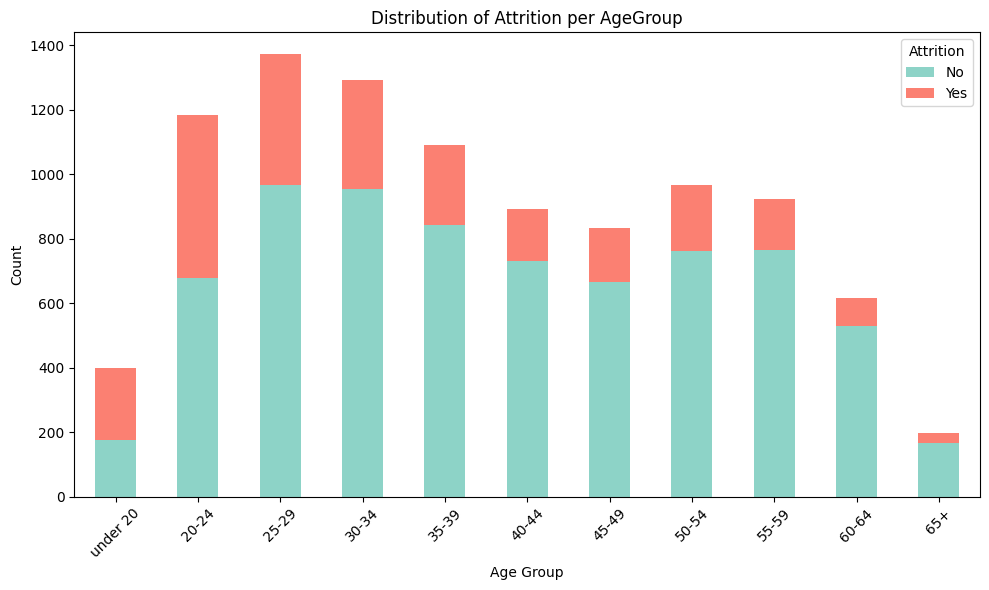

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the order of the AgeGroup
age_order = [
    'under 20',   # 0
    '20-24',      # 1
    '25-29',      # 2
    '30-34',      # 3
    '35-39',      # 4
    '40-44',      # 5
    '45-49',      # 6
    '50-54',      # 7
    '55-59',      # 8
    '60-64',      # 9
    '65+'         # 10
]

# Copy the DataFrame to ensure original df_employees_cleaned is not changed
df_copy = df_employees_cleaned.copy()

# Convert Attrition to numeric values (0 for 'No', 1 for 'Yes')
df_copy['Attrition'] = df_copy['Attrition'].map({'No': 0, 'Yes': 1})

# Create a cross-tabulation of AgeGroup and Attrition
attrition_agegroup = pd.crosstab(df_copy['AgeGroup'], df_copy['Attrition'])

# Ensure the data is numeric (just in case)
attrition_agegroup = attrition_agegroup.astype(int)

# Get the first and third colors from Set3 color palette (more visible alternative)
colors = [sns.color_palette("Set3", n_colors=12)[0], sns.color_palette("Set3", n_colors=12)[3]]  # First and third colors

# Plotting a stacked bar plot
ax = attrition_agegroup.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)

# Add title and labels
ax.set_title('Distribution of Attrition per AgeGroup')
ax.set_xlabel('Age Group')
ax.set_ylabel('Count')

# Set custom labels for the x-axis using the age_order (use the original labels)
ax.set_xticklabels(age_order, rotation=45)

# Add legend and show the plot
ax.legend(title='Attrition', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()




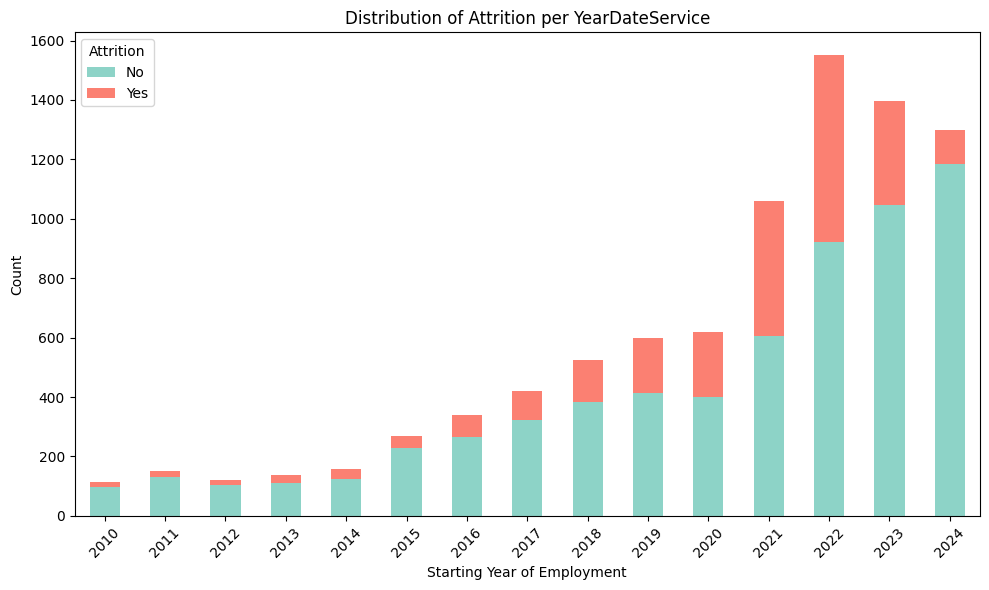

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the year range
min_year = 1977
max_year = 2024

# Create a mapping from year to ordinal value
year_mapping = {year: year - min_year for year in range(min_year, max_year + 1)}

# Copy the DataFrame to ensure original df_employees_cleaned is not changed
df_copy = df_employees_cleaned.copy()

# Convert Attrition to numeric values (0 for 'No', 1 for 'Yes')
df_copy['Attrition'] = df_copy['Attrition'].map({'No': 0, 'Yes': 1})

# Create a cross-tabulation of YearDateService and Attrition
attrition_service_year = pd.crosstab(df_copy['YearDateService'], df_copy['Attrition'], margins=False)

# Ensure the data is numeric (just in case)
attrition_service_year = attrition_service_year.astype(int)

# Get the first and third colors from Set3 color palette (more visible alternative)
colors = [sns.color_palette("Set3", n_colors=12)[0], sns.color_palette("Set3", n_colors=12)[3]]  # First and third colors

# Map the ordinal year values back to the original years for plotting (use the reverse of year_mapping)
reverse_year_mapping = {v: k for k, v in year_mapping.items()}
attrition_service_year.index = attrition_service_year.index.map(reverse_year_mapping)

# Get the last 15 years (from 2009 to 2024)
last_15_years = attrition_service_year.tail(15)

# Plotting a stacked bar plot for the last 15 years only
ax = last_15_years.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)

# Add title and labels
ax.set_title('Distribution of Attrition per YearDateService')
ax.set_xlabel('Starting Year of Employment')
ax.set_ylabel('Count')

# Set custom labels for the x-axis using the YearDateService (now in original year format)
ax.set_xticklabels(last_15_years.index, rotation=45)

# Add legend and show the plot
ax.legend(title='Attrition', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()



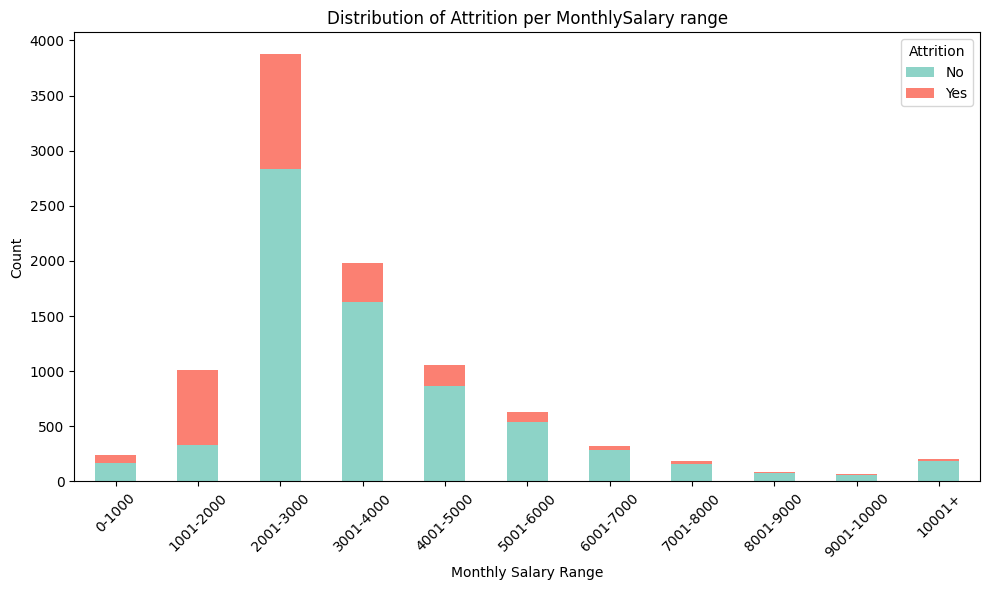

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_attrition_by_salary_range(df, salary_column, title, xlabel, ylabel):
    """
    Plots a stacked bar chart showing the distribution of Attrition based on salary ranges.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame containing employee data.
    - salary_column (str): The column representing the monthly salary.
    - title (str): The title of the plot.
    - xlabel (str): Label for the x-axis.
    - ylabel (str): Label for the y-axis.
    """
    # Copy the DataFrame to ensure the original is not modified
    df_copy = df.copy()

    # Define cleaner salary bins and labels
    salary_bins = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, float('inf')]
    salary_labels = ['0-1000', '1001-2000', '2001-3000', '3001-4000', 
                     '4001-5000', '5001-6000', '6001-7000', '7001-8000', 
                     '8001-9000', '9001-10000', '10001+']

    # Create a new column for salary ranges
    df_copy['SalaryRange'] = pd.cut(df_copy[salary_column], bins=salary_bins, labels=salary_labels, right=True)

    # Convert Attrition to numeric values (0 for 'No', 1 for 'Yes')
    df_copy['Attrition'] = df_copy['Attrition'].map({'No': 0, 'Yes': 1})

    # Create a cross-tabulation of SalaryRange and Attrition
    attrition_salary_range = pd.crosstab(df_copy['SalaryRange'], df_copy['Attrition'], margins=False)

    # Ensure the data is numeric (just in case)
    attrition_salary_range = attrition_salary_range.astype(int)

    # Get the first and third colors from Set3 color palette (more visible alternative)
    colors = [sns.color_palette("Set3", n_colors=12)[0], sns.color_palette("Set3", n_colors=12)[3]]

    # Plotting a stacked bar plot for salary ranges
    ax = attrition_salary_range.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)

    # Add title and labels
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Set custom labels for the x-axis
    ax.set_xticklabels(attrition_salary_range.index, rotation=45)

    # Add legend and show the plot
    ax.legend(title='Attrition', labels=['No', 'Yes'])
    plt.tight_layout()
    plt.show()

# Example usage:
plot_attrition_by_salary_range(
    df=df_employees_cleaned,
    salary_column='MonthlySalary',
    title='Distribution of Attrition per MonthlySalary range',
    xlabel='Monthly Salary Range',
    ylabel='Count'
)



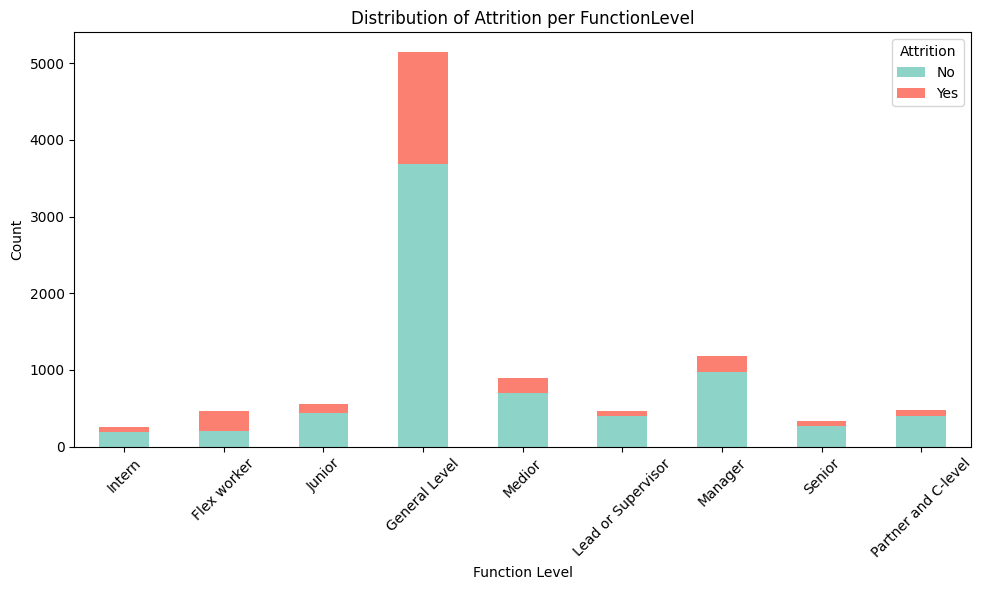

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_attrition_by_function_level(df, function_level_column, title, xlabel, ylabel):
    """
    Plots a stacked bar chart showing the distribution of Attrition based on FunctionLevel with custom labels.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame containing employee data.
    - function_level_column (str): The column representing the Function Level.
    - title (str): The title of the plot.
    - xlabel (str): Label for the x-axis.
    - ylabel (str): Label for the y-axis.
    """
    # Define the order of categories
    category_order = [
        'Intern', 
        'Flex worker', 
        'Junior', 
        'General Level', 
        'Medior', 
        'Lead or Supervisor', 
        'Manager', 
        'Senior', 
        'Partner and C-level'
    ]
    
    # Create a mapping from category to ordinal number
    category_mapping = {category: index for index, category in enumerate(category_order)}

    # Copy the DataFrame to ensure the original is not modified
    df_copy = df.copy()

    # Perform ordinal encoding
    df_copy['FunctionLevel'] = df_copy[function_level_column].replace(category_mapping)

    # Convert Attrition to numeric values (0 for 'No', 1 for 'Yes')
    df_copy['Attrition'] = df_copy['Attrition'].map({'No': 0, 'Yes': 1})

    # Create a cross-tabulation of FunctionLevel and Attrition
    attrition_function_level = pd.crosstab(df_copy['FunctionLevel'], df_copy['Attrition'], margins=False)

    # Ensure the data is numeric (just in case)
    attrition_function_level = attrition_function_level.astype(int)

    # Get the first and third colors from Set3 color palette (more visible alternative)
    colors = [sns.color_palette("Set3", n_colors=12)[0], sns.color_palette("Set3", n_colors=12)[3]]

    # Plotting a stacked bar plot for FunctionLevel
    ax = attrition_function_level.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)

    # Add title and labels
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Set custom labels for the x-axis using the FunctionLevel labels (map ordinal back to category labels)
    ax.set_xticklabels(category_order, rotation=45)

    # Add legend and show the plot
    ax.legend(title='Attrition', labels=['No', 'Yes'])
    plt.tight_layout()
    plt.show()

# Example usage:
plot_attrition_by_function_level(
    df=df_employees_cleaned,
    function_level_column='FunctionLevel',  # This column should be 'FunctionLevel'
    title='Distribution of Attrition per FunctionLevel',
    xlabel='Function Level',
    ylabel='Count'
)



# AUC-ROC and AUC-PR plots

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5793, number of negative: 5793
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2067
[LightGBM] [Info] Number of data points in the train set: 11586, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/root/.ipykernel/1703/command-833495483671375-2410270489:58: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  axes[0].plot([0, 1], [0, 1], 'k--', label='Random', color='gray')  # Diagonal line


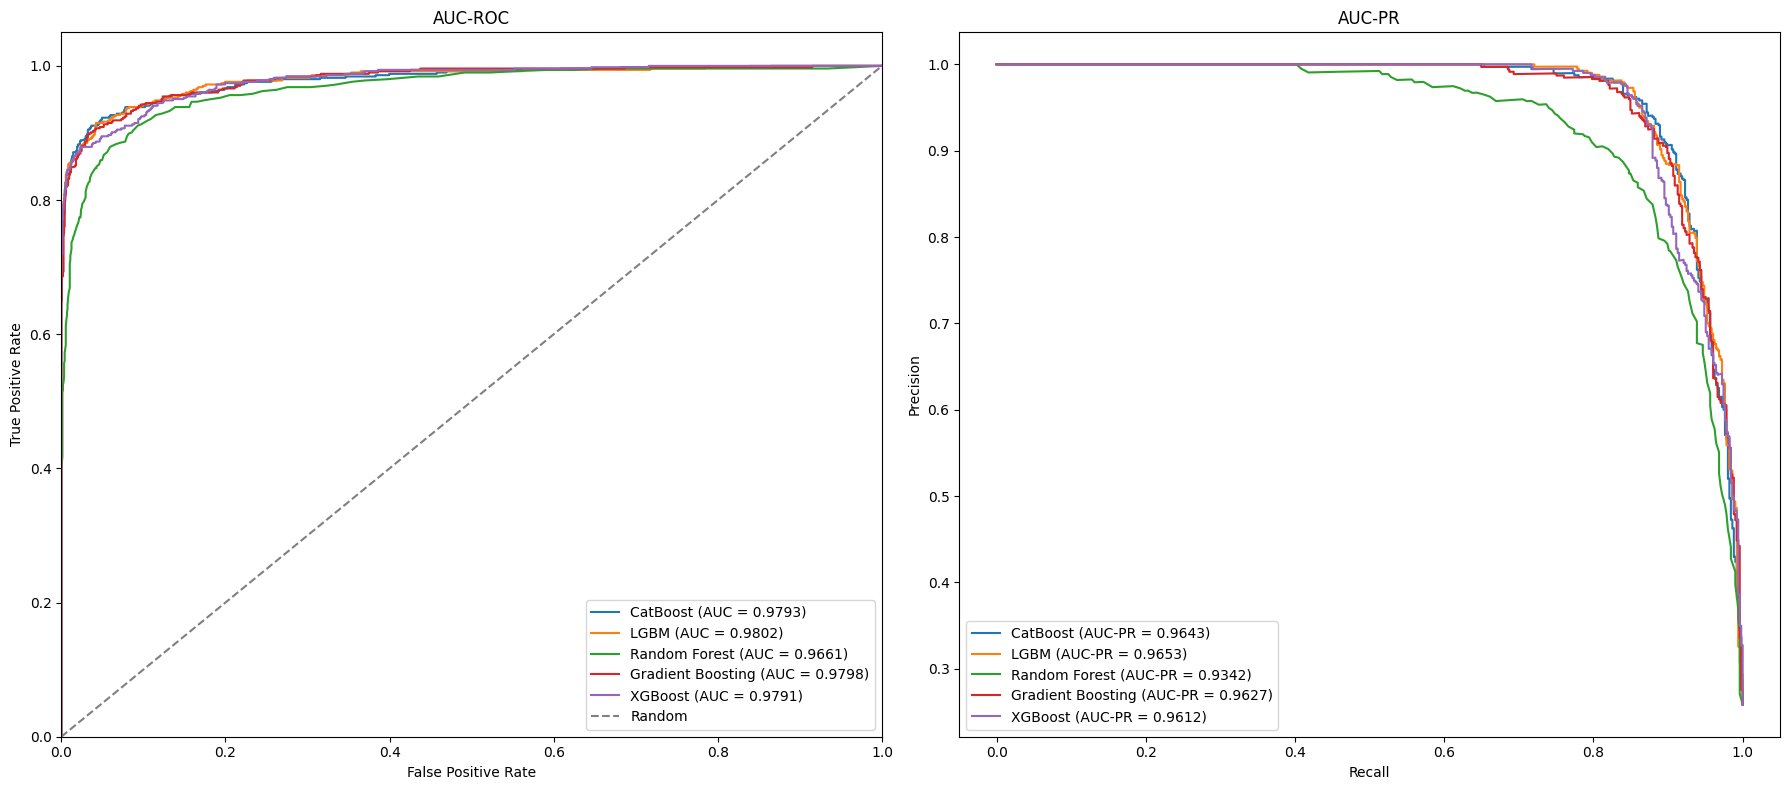

In [0]:
# Import necessary libraries
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# Initialize dictionaries to store the metrics
fpr_dict = {}
tpr_dict = {}
roc_auc_values = {}
precision_dict = {}
recall_dict = {}
pr_auc_values = {}

# Define the models dictionary with all the classifiers
models = {
    'CatBoost': final_catboost_classifier,
    'LGBM': final_lgbm_classifier,
    'Random Forest': final_rf_classifier,
    'Gradient Boosting': final_gbm_classifier,
    'XGBoost': final_xgb_classifier  # Ensure you have this model defined
}

# Calculate ROC and AUC values, and Precision-Recall for each model
for model_name, model in models.items():
    # Fit the model to the resampled training data
    model.fit(X_train_resampled, y_train_resampled)
    
    # Get the predicted probabilities (for the positive class)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Store ROC values
    fpr_dict[model_name] = fpr
    tpr_dict[model_name] = tpr
    roc_auc_values[model_name] = roc_auc
    
    # Compute Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    
    # Store Precision-Recall values
    precision_dict[model_name] = precision
    recall_dict[model_name] = recall
    pr_auc_values[model_name] = pr_auc

# Create subplots with two plots side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot the ROC curves
for model_name in roc_auc_values.keys():
    axes[0].plot(fpr_dict[model_name], tpr_dict[model_name], label=f'{model_name} (AUC = {roc_auc_values[model_name]:.4f})')

axes[0].plot([0, 1], [0, 1], 'k--', label='Random', color='gray')  # Diagonal line
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('AUC-ROC')
axes[0].legend(loc="lower right")

# Plot the Precision-Recall curves
for model_name in pr_auc_values.keys():
    axes[1].plot(recall_dict[model_name], precision_dict[model_name], label=f'{model_name} (AUC-PR = {pr_auc_values[model_name]:.4f})')

axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('AUC-PR')
axes[1].legend(loc="lower left")

plt.tight_layout()
plt.show()





